In [1]:
""" 
SOAR Offline Laptime Optimization for Reference Trajectory Generation
AA 203/273 Spring 2024
Andrew Wang, Bryan Yang
"""
import numpy as np
from pyomo.environ import *
from pyomo.dae import *
import matplotlib.pyplot as plt
from agents import BicycleVehicle
from config import *

In [2]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# L Track Optimization

In [4]:
# Set up L track for optimization
L_veh_config = get_vehicle_config()
L_scene_config = get_scene_config(track_type=L_TRACK)
L_veh_constraints = get_vehicle_opt_constraints(L_veh_config, L_scene_config)
L_track = L_scene_config["track"]

In [5]:
print(L_track.name)

L TRACK w/Straight 1000, Curve Radius 500


In [6]:
def plot_racelines(track, raceline):
    import matplotlib.pyplot as plt
    import os

#     track = get_track(track_name)

    fig_xy = plt.figure(figsize=(20, 20))
    ax = fig_xy.gca()
    track.plotTrack(ax)

    fig_ts = plt.figure(figsize=(50, 30))
    ax_s = fig_ts.add_subplot(10, 1, 1)
    ax_s.set_ylabel('s')
    ax_ey = fig_ts.add_subplot(10, 1, 2)
    ax_ey.set_ylabel('ey')
    ax_ep = fig_ts.add_subplot(10, 1, 3)
    ax_ep.set_ylabel('epsi')
    ax_vx = fig_ts.add_subplot(10, 1, 4)
    ax_vx.set_ylabel('vx')
    ax_vy = fig_ts.add_subplot(10, 1, 5)
    ax_vy.set_ylabel('vy')
    ax_om = fig_ts.add_subplot(10, 1, 6)
    ax_om.set_ylabel('omega')
    ax_delta = fig_ts.add_subplot(10, 1, 7)
    ax_delta.set_ylabel('delta')
    ax_ua = fig_ts.add_subplot(10, 1, 8)
    ax_ua.set_ylabel('u_accel')
    ax_us = fig_ts.add_subplot(10, 1, 9)
    ax_us.set_ylabel('u_steer (ddelta)')
    ax_s.set_xlabel('t')

#     vs = np.cos(raceline['v_long']) - np.sin(raceline['v_tran'])
    speed = np.sqrt(np.power(raceline['v_long'],2)+np.power(raceline['v_tran'],2))
    sc = ax.scatter(raceline['x'], raceline['y'], c=speed)
    ax.plot(raceline['x'], raceline['y'], 'b')

    ax_s.plot(raceline['t'], raceline['s'], 'b')
    ax_ey.plot(raceline['t'], raceline['e_y'], 'b')
    ax_ep.plot(raceline['t'], raceline['e_psi'], 'b')
    ax_vx.plot(raceline['t'], raceline['v_long'], 'b')
    ax_vy.plot(raceline['t'], raceline['v_tran'], 'b')
    ax_om.plot(raceline['t'], raceline['psidot'], 'b')
    ax_delta.plot(raceline['t'], raceline['delta'], 'b')
    ax_ua.plot(raceline['t'], raceline['u_a'], 'b')
    ax_us.plot(raceline['t'], raceline['u_s'], 'b')

    laptime = raceline['t'][-1]
    print(f'Lap time: {laptime}')

    ax.set_aspect('equal')
    plt.colorbar(mappable=sc, ax=ax)
    ax.set_title(f'time: {laptime:.2f} s')

    plt.draw()

In [9]:
def compute_raceline(track, vehicle_config, vehicle_constraints):

    #SYSTEM STATES:  vx=x[0],  vy=x[1], wz=x[2] ,e_psi=x[3], t=x[4], e_y=x[5]
    #SYSTEM INPUTS:  ax[m/s^2]=u0, steeringrate(rad/s)=u1
    #INDEPENDENT VARIABLE IS s (space)

    lf = vehicle_config["lf"]
    lr = vehicle_config["lr"]

    mass = vehicle_config["m"]
    Iz = vehicle_config["Iz"]

    c_alpha_f = vehicle_config["c"]
    c_alpha_r = vehicle_config["c"]
    
    Cd = vehicle_config["Cd"]
    SA = vehicle_config["SA"]
    C_downforce = vehicle_config["downforce_coeff"]
    
    v_long_max = vehicle_constraints["ub_vx"]
    v_long_min = vehicle_constraints["lb_vx"]
    v_tran_max = vehicle_constraints["ub_vy"]
    v_tran_min = vehicle_constraints["lb_vy"]
    psidot_max = vehicle_constraints["ub_omega"]
    psidot_min = vehicle_constraints["lb_omega"]
    e_psi_max = vehicle_constraints["ub_epsi"]
    e_psi_min = vehicle_constraints["lb_epsi"]
    e_y_max = vehicle_constraints["ub_ey"]
    e_y_min = vehicle_constraints["lb_ey"]
    steer_max = vehicle_constraints["ub_delta"]
    steer_min = vehicle_constraints["lb_delta"]

    a_max = vehicle_config["max_accel"]
    a_min = -vehicle_config["max_accel"]
    steer_rate_max = vehicle_config["max_steer_rate"]
    steer_rate_min = -vehicle_config["max_steer_rate"]

#     a_rate_max = du_ub.u_a
#     a_rate_min = du_lb.u_a


    print('=================== Raceline computation ===================')
    print('Track name: %s' % track.name)
    print('     - length: %g m' % track.total_len)
    print('     - width: %g m' % (track.half_width*2))
    print('Vehicle configuration:')
    print('     - center of mass to front axle: %g m' % lf)
    print('     - center of mass to rear axle: %g m' % lr)
    print('     - mass: %g kg' % mass)
    print('     - yaw inertia: %g kg m^2' % Iz)
    print('     - Drag Coefficient: %g' % Cd)
    print('     - frontal area: %g m^2' % SA)
#     print('     - tire model: %s' % tire_model)
#     print('     - tire friction coefficient: %g' % mu)
#     print('     - Front tires:')
#     print('         - B: %g' % Bf)
#     print('         - C: %g' % Cf)
#     print('         - D: %g' % Df)
#     print('     - Rear tires:')
#     print('         - B: %g' % Br)
#     print('         - C: %g' % Cr)
#     print('         - D: %g' % Dr)
    print('Vehicle input constraints:')
    print('     - max acceleration: %g m/s^2' % a_max)
    print('     - min acceleration: %g m/s^2' % a_min)
    print('     - max steering angle: %g rad' % steer_max)
    print('     - min steering angle: %g rad' % steer_min)
    print('Vehicle state constraints:')
    print('     - max longitudinal velocity: %g m/s' % v_long_max)
    print('     - min longitudinal velocity: %g m/s' % v_long_min)
    print('     - max lateral velocity: %g m/s' % v_tran_max)
    print('     - min lateral velocity: %g m/s' % v_tran_min)
    print('     - max yaw rate: %g rad/s' % psidot_max)
    print('     - min yaw rate: %g rad/s' % psidot_min)
    print('============================================================')

    model = m = ConcreteModel()
    m.sf = Param(initialize=track.total_len)
    m.s = ContinuousSet(bounds=(0, m.sf), initialize=np.linspace(0, track.total_len, 1000))       #s
#     m.s = ContinuousSet(bounds=(0, m.sf))                             #s


    m.u0 = Var(m.s, bounds=(a_min, a_max), initialize=0)
#     m.u1 = Var(m.s, bounds=(steer_min, steer_max), initialize=0)
    m.u1 = Var(m.s, bounds=(steer_rate_min, steer_rate_max), initialize=0)
    m.alpha_f = Var(m.s, initialize=0)
    m.alpha_r = Var(m.s, initialize=0)
    m.Fyf = Var(m.s,bounds=(-mass*9.8*C_downforce, mass*9.8*C_downforce), initialize=0)
    m.Fyr = Var(m.s,bounds=(-mass*9.8*C_downforce, mass*9.8*C_downforce), initialize=0)
    m.x0 = Var(m.s, bounds=(v_long_min, v_long_max), initialize=100)  #vx
    m.x1 = Var(m.s, bounds=(v_tran_min, v_tran_max), initialize=0)    #vy
    m.x2 = Var(m.s, bounds=(psidot_min, psidot_max), initialize=0)    #omega
    m.x3 = Var(m.s, bounds=(e_psi_min, e_psi_max), initialize=0)      #epsi
    def _t_init(m, s):
        return s/track.total_len * 30
    m.x4 = Var(m.s, bounds=(0, 2000), initialize=_t_init)             #t
    m.x5 = Var(m.s, bounds=(e_y_min, e_y_max), initialize=0)          #ey
    m.x6 = Var(m.s, bounds=(steer_min, steer_max), initialize=0)      #delta

    m.dx0ds = DerivativeVar(m.x0, wrt=m.s)
    m.dx1ds = DerivativeVar(m.x1, wrt=m.s)
    m.dx2ds = DerivativeVar(m.x2, wrt=m.s)
    m.dx3ds = DerivativeVar(m.x3, wrt=m.s)
    m.dx4ds = DerivativeVar(m.x4, wrt=m.s)
    m.dx5ds = DerivativeVar(m.x5, wrt=m.s)
    m.dx6ds = DerivativeVar(m.x6, wrt=m.s)
    m.du0ds = DerivativeVar(m.u0, wrt=m.s)
    m.du1ds = DerivativeVar(m.u1, wrt=m.s)

    # to avoid divide by 0
    eps=0.000001

    #Objective function
#     m.obj = Objective(expr=m.x4[m.sf] + 0.01*sum(m.du0ds[i]**2 for i in m.s) + 0.01*sum(m.du1ds[i]**2 for i in m.s), sense=minimize)
#     m.obj = Objective(expr=m.x4[m.sf], sense=minimize) # + 0.01*sum(m.du0ds[i]**2 for i in m.s) + 0.01*sum(m.u1[i]**2 for i in m.s), sense=minimize)
    m.obj = Objective(expr=m.x4[m.sf] + 0.01*sum(m.du0ds[i]**2 for i in m.s) + 0.1*sum(m.u1[i]**2 for i in m.s), sense=minimize)
    # ways to tune the cost:
        # penalize u1
        # penalize u2
        # penalize u1 and u2
        # vary the penalizations on u1 and u2
        # penalize the input rate
    # to do: write this optimization problem as a function that gets called
    # different arguments will choose a different objective tuning
    # function output should be the DF, then we can store them all

    #sideslip and lateral force
    def _alphafc(m, s):
        # alpha = delta - atan((vy+lf*w)/vx)
        return m.alpha_f[s] == m.x6[s] - atan((m.x1[s] + lf * m.x2[s])/ (m.x0[s]))
    m.c4 = Constraint(m.s, rule=_alphafc)
    def _alpharc(m, s):
        # alpha = - atan((vy-lr*w)/vx)
        return m.alpha_r[s] == -atan((m.x1[s] - lr * m.x2[s])/ (m.x0[s]))
    m.c3 = Constraint(m.s, rule=_alpharc)
    def sdot_inv(m, s, cur):
        return (1 - cur*m.x5[s]) / (eps + m.x0[s]*cos(m.x3[s]) - m.x1[s]*sin(m.x3[s]))
        
    def _Fyfc(m, s):
        return m.Fyf[s] ==  c_alpha_f * m.alpha_f[s]
    m.c2 = Constraint(m.s, rule=_Fyfc)
    def _Fyrc(m, s):
        return m.Fyr[s] ==  c_alpha_r * m.alpha_r[s]
    m.c1 = Constraint(m.s, rule=_Fyrc)

    #Differential model definition
    def _x0dot(m, s):
        cur = track.getCurvature(s)
        # print(cur)
        # dvx/ds = vxdot/sdot = (a - (Fd/m + Fyfsin(delta)/m + omega*vy)*(1-kappa*ey) / (eps+vx*cos(epsi) - vy*sin(epsi))
        return m.dx0ds[s] == (m.u0[s] - (m.Fyf[s]*sin(m.x6[s])/mass) - (0.5*Cd*SA*m.x0[s]**2/mass) + m.x2[s]*m.x1[s])*sdot_inv(m, s, cur)
    m.x0dot = Constraint(m.s, rule=_x0dot)

    def _x1dot(m, s):
        cur = track.getCurvature(s)
        # dvy/ds = vydot/sdot = 1/m*(Fyfcos(delta)+Fyr) + omega*vx)*(1-kappa*ey) / (eps+vx*cos(epsi) - vy*sin(epsi))
        return m.dx1ds[s] == (1 / mass * (m.Fyf[s]*cos(m.x6[s]) + m.Fyr[s]) - m.x2[s]*m.x0[s])*((1 - cur * m.x5[s]) /(eps+m.x0[s] * cos(m.x3[s]) - m.x1[s] * sin(m.x3[s])))
    m.x1dot = Constraint(m.s, rule=_x1dot)

    def _x2dot(m, s):
        cur = track.getCurvature(s)
        # dw/ds = wdot/sdot = 1/Iz*(lf*Fyfcos(delta) - lrFyr)*(1-kappa*ey) / (eps+vx*cos(epsi) - vy*sin(epsi))
        return m.dx2ds[s] == (1 / Iz *(lf*m.Fyf[s] * cos(m.x6[s]) - lr * m.Fyr[s]) )*((1 - cur * m.x5[s]) /(eps+m.x0[s] * cos(m.x3[s]) - m.x1[s] * sin(m.x3[s])))
    m.x2dot = Constraint(m.s, rule=_x2dot)

    def _x3dot(m, s):
        cur = track.getCurvature(s)
        # dw/ds = epsidot/sdot = (omega - kappa*sdot)*(1-kappa*ey) / (eps+vx*cos(epsi) - vy*sin(epsi)) = omega*(1-kappa*ey) / (eps+vx*cos(epsi) - vy*sin(epsi)) - kappa
        return m.dx3ds[s] == ( m.x2[s]*(1 - cur * m.x5[s])/(eps+m.x0[s] * cos(m.x3[s]) - m.x1[s] * sin(m.x3[s])) - cur)
    m.x3dot = Constraint(m.s, rule=_x3dot)

    def _x4dot(m, s):
        cur = track.getCurvature(s)
        # dt/ds = 1/sdot = (1-kappa*ey) / (eps+vx*cos(epsi) - vy*sin(epsi))
        return m.dx4ds[s] == ((1 - cur * m.x5[s]) /(eps+m.x0[s] * cos(m.x3[s]) - m.x1[s] * sin(m.x3[s])))
    m.x4dot = Constraint(m.s, rule=_x4dot)

    def _x5dot(m, s):
        cur = track.getCurvature(s)
        # dey/ds = eydot/sdot = (vxsin(epsi) + vycos(epsi))*(1-kappa*ey) / (eps+vx*cos(epsi) - vy*sin(epsi))
        return m.dx5ds[s] == (m.x0[s] * sin(m.x3[s]) + m.x1[s] * cos(m.x3[s]))*((1 - cur * m.x5[s]) /(eps+m.x0[s] * cos(m.x3[s]) - m.x1[s] * sin(m.x3[s])))
    m.x5dot = Constraint(m.s, rule=_x5dot)
    
    def _x6dot(m, s):
        cur = track.getCurvature(s)
        # ddelta/ds = deltadot/sdot = (ddelta)*(1-kappa*ey) / (eps+vx*cos(epsi) - vy*sin(epsi))
        return m.dx6ds[s] == m.u1[s]*((1 - cur * m.x5[s]) /(eps+m.x0[s] * cos(m.x3[s]) - m.x1[s] * sin(m.x3[s])))
    m.x6dot = Constraint(m.s, rule=_x6dot)

#     # rate constraints on acceleration
#     def _u0dotmax(m, s):
#         cur = track.getCurvature(s)
#         return m.du0ds[s] <= a_rate_max*((1 - cur * m.x5[s]) /(eps+m.x0[s] * cos(m.x3[s]) - m.x1[s] * sin(m.x3[s])))
#     m.i0dotub = Constraint(m.s, rule=_u0dotmax)
#     def _u0dotmin(m, s):
#         cur = track.get_curvature(s)
#         return m.du0ds[s] >= a_rate_min*((1 - cur * m.x5[s]) /(eps+m.x0[s] * cos(m.x3[s]) - m.x1[s] * sin(m.x3[s])))
#     m.i0dotlb = Constraint(m.s, rule=_u0dotmin)

#     rate constraints on steering
#     def _u1dotmax(m, s):
#         cur = track.get_curvature(s)
#         return m.du1ds[s] <= steer_rate_max*((1 - cur * m.x5[s]) /(eps+m.x0[s] * cos(m.x3[s]) - m.x1[s] * sin(m.x3[s])))
#     m.i1dotub = Constraint(m.s, rule=_u1dotmax)
#     def _u1dotmin(m, s):
#         cur = track.get_curvature(s)
#         return m.du1ds[s] >= steer_rate_min*((1 - cur * m.x5[s]) /(eps+m.x0[s] * cos(m.x3[s]) - m.x1[s] * sin(m.x3[s])))
#     m.i1dotlb = Constraint(m.s, rule=_u1dotmin)

    # inital and terminal conditions
    def _init(m):
        yield m.x0[0] == m.x0[track.total_len] #vx
        yield m.x1[0] == m.x1[track.total_len] #vy
        yield m.x2[0] == m.x2[track.total_len] #w
        yield m.x3[0] == m.x3[track.total_len] #epsi
        yield m.x4[0] == 0 #t
        yield m.x5[0] == m.x5[track.total_len] #ey
        yield m.x6[0] == m.x6[track.total_len] #delta
#         yield m.x0[0] == 0 #vx
#         yield m.x1[0] == 0 #vy
#         yield m.x2[0] == 0 #w
#         yield m.x3[0] == 0 #epsi
#         yield m.x4[0] == 0 #t
#         yield m.x5[0] == 0 #ey
#         yield m.x6[0] == 0 #delta
    m.init_conditions = ConstraintList(rule=_init)

    # Discretize model using radau or finite difference collocation
#     TransformationFactory('dae.collocation').apply_to(m, nfe=100, ncp=4, scheme='LAGRANGE-LEGENDRE') #STANDARD METHOD
    TransformationFactory('dae.collocation').apply_to(m, ncp=1, scheme='LAGRANGE-LEGENDRE') #STANDARD METHOD

    # Solve algebraic model
    solver = SolverFactory('ipopt')
    # Solver options
    solver.options['max_iter'] = 10000
    results = solver.solve(m,tee=True)

    # Evaluate solution at discretization points
    s_vec = list(sorted(m.s.data()))

    raceline = {'t': np.zeros(len(s_vec)),
                'x' : np.zeros(len(s_vec)),
                'y' : np.zeros(len(s_vec)),
                'psi' : np.zeros(len(s_vec)),
                's' : np.zeros(len(s_vec)),
                'e_y' : np.zeros(len(s_vec)),
                'e_psi' : np.zeros(len(s_vec)),
                'delta' : np.zeros(len(s_vec)),
                'v_long' : np.zeros(len(s_vec)),
                'v_tran' : np.zeros(len(s_vec)),
                'psidot' : np.zeros(len(s_vec)),
                'u_a': np.zeros(len(s_vec)),
                'u_s': np.zeros(len(s_vec))}

    for j in range(len(s_vec)):
        s = s_vec[j]
        
        vx = value(m.x0[s])
        vy = value(m.x1[s])
        w = value(m.x2[s])
        epsi = value(m.x3[s])
        t = value(m.x4[s])
        ey = value(m.x5[s])
        delta = value(m.x6[s])
        a = value(m.u0[s])
        ddelta = value(m.u1[s])
        
        cl_state = np.array([s, ey, epsi, vx, vy, w, delta])
        global_state = track.CLtoGlobal(cl_state)
        x, y, theta, vx_g, vy_g, w_g, delta_g = global_state

        raceline['t'][j] = t
        raceline['v_long'][j] = vx
        raceline['v_tran'][j] = vy
        raceline['psidot'][j] = w
        raceline['s'][j] = s
        raceline['e_y'][j] = ey
        raceline['e_psi'][j] = epsi
        raceline['delta'][j] = delta
        raceline['x'][j] = x
        raceline['y'][j] = y
        raceline['psi'][j] = theta
        raceline['u_a'][j] = a
        raceline['u_s'][j] = ddelta

    return raceline



In [10]:
raceline = compute_raceline(track, veh_config, veh_constraints)

=================== Raceline computation ===================
Track name: L TRACK w/Straight 1000, Curve Radius 500
     - length: 6712.39 m
     - width: 30 m
Vehicle configuration:
     - center of mass to front axle: 2.5 m
     - center of mass to rear axle: 2 m
     - mass: 800 kg
     - yaw inertia: 1800 kg m^2
     - Drag Coefficient: 0.56
     - frontal area: 2 m^2
     - Front Tire Coefficient : 210000 N/rad
     - Rear Tire Coefficient : 210000 N/rad
Vehicle input constraints:
     - max acceleration: 10 m/s^2
     - min acceleration: -10 m/s^2
     - max steering angle: 0.5 rad
     - min steering angle: -0.5 rad
Vehicle state constraints:
     - max longitudinal velocity: 200 m/s
     - min longitudinal velocity: 0 m/s
     - max lateral velocity: 2 m/s
     - min lateral velocity: -2 m/s
     - max yaw rate: 1 rad/s
     - min yaw rate: -1 rad/s
of finite elements specified in apply. The larger number of finite elements
will be used.
Ipopt 3.13.4: max_iter=10000


**********

  65  1.2009491e+02 8.10e-02 2.76e+03  -1.0 6.93e+02  -1.9 1.65e-02 4.47e-02h  1
  66  1.2188155e+02 7.71e-02 2.63e+03  -1.0 1.13e+02  -1.5 4.35e-02 4.93e-02h  1
  67  1.2319526e+02 7.44e-02 2.64e+03  -1.0 3.35e+02  -2.0 2.22e-02 3.54e-02h  1
  68  1.2542657e+02 6.96e-02 5.50e+03  -1.0 1.22e+02  -1.5 2.32e-02 6.58e-02h  1
  69  1.2589702e+02 6.85e-02 2.66e+03  -1.0 6.56e+01  -1.1 3.69e-02 1.58e-02h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  70  1.2775707e+02 6.46e-02 3.23e+03  -1.0 2.06e+02  -1.6 1.23e-02 5.79e-02h  1
  71  1.2778583e+02 6.45e-02 2.79e+03  -1.0 1.10e+02  -1.2 2.95e-02 1.02e-03h  1
  72  1.2810438e+02 6.38e-02 2.76e+03  -1.0 4.71e+01  -0.7 1.04e-02 1.22e-02h  1
  73  1.2811772e+02 6.37e-02 2.76e+03  -1.0 1.20e+02  -1.2 1.77e-02 4.61e-04h  1
  74  1.2862189e+02 6.26e-02 2.72e+03  -1.0 5.11e+01  -0.8 9.00e-03 1.83e-02f  1
  75  1.2873905e+02 6.23e-02 2.71e+03  -1.0 1.27e+02  -1.3 9.44e-03 3.99e-03h  1
  76  1.2875870e+02 6.23e-02

In [130]:
def plot_racelines(track, raceline):
    import matplotlib.pyplot as plt
    import os

#     track = get_track(track_name)

    fig_xy = plt.figure(figsize=(20, 20))
    ax = fig_xy.gca()
    track.plotTrack(ax)

    fig_ts = plt.figure(figsize=(50, 30))
    ax_s = fig_ts.add_subplot(9, 1, 1)
    ax_s.set_ylabel('s')
    ax_ey = fig_ts.add_subplot(9, 1, 2)
    ax_ey.set_ylabel('ey')
    ax_ep = fig_ts.add_subplot(9, 1, 3)
    ax_ep.set_ylabel('epsi')
    ax_vx = fig_ts.add_subplot(9, 1, 4)
    ax_vx.set_ylabel('vx')
    ax_vy = fig_ts.add_subplot(9, 1, 5)
    ax_vy.set_ylabel('vy')
    ax_om = fig_ts.add_subplot(9, 1, 6)
    ax_om.set_ylabel('omega')
    ax_delta = fig_ts.add_subplot(9, 1, 7)
    ax_delta.set_ylabel('delta')
    ax_ua = fig_ts.add_subplot(9, 1, 8)
    ax_ua.set_ylabel('u_accel')
    ax_us = fig_ts.add_subplot(9, 1, 9)
    ax_us.set_ylabel('u_steer (ddelta)')
    ax_s.set_xlabel('t')

#     vs = np.cos(raceline['v_long']) - np.sin(raceline['v_tran'])
    speed = np.sqrt(np.power(raceline['v_long'],2)+np.power(raceline['v_tran'],2))
    sc = ax.scatter(raceline['x'], raceline['y'], c=speed)
    ax.plot(raceline['x'], raceline['y'], 'b')

    ax_s.plot(raceline['t'], raceline['s'], 'b')
    ax_ey.plot(raceline['t'], raceline['e_y'], 'b')
    ax_ep.plot(raceline['t'], raceline['e_psi'], 'b')
    ax_vx.plot(raceline['t'], raceline['v_long'], 'b')
    ax_vy.plot(raceline['t'], raceline['v_tran'], 'b')
    ax_om.plot(raceline['t'], raceline['psidot'], 'b')
    ax_delta.plot(raceline['t'], raceline['delta'], 'b')
    ax_ua.plot(raceline['t'], raceline['u_a'], 'b')
    ax_us.plot(raceline['t'], raceline['u_s'], 'b')

    laptime = raceline['t'][-1]
    print(f'Lap time: {laptime}')

    ax.set_aspect('equal')
    plt.colorbar(mappable=sc, ax=ax)
    ax.set_title(f'time: {laptime:.2f} s')

    plt.draw()

In [196]:
L_raceline, L_model = compute_raceline(L_track, L_veh_config, L_veh_constraints)

 158  1.5691292e+02 1.03e-02 1.35e+04  -1.0 1.49e+01  -1.1 1.65e-02 9.87e-02h  1
 159  1.5693058e+02 1.03e-02 1.32e+04  -1.0 9.01e+00  -0.7 3.58e-02 3.13e-03h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 160  1.5813807e+02 8.15e-03 1.96e+04  -1.0 8.77e+00  -1.2 3.99e-02 2.06e-01f  1
 161  1.5845534e+02 7.61e-03 8.02e+03  -1.0 8.77e+00  -1.7 2.20e-01 6.69e-02f  1
 162  1.5868525e+02 7.21e-03 7.31e+03  -1.0 1.45e+01  -1.2 1.46e-01 5.28e-02f  1
 163  1.6004078e+02 4.94e-03 1.51e+04  -1.0 2.00e+01  -1.7 5.45e-02 3.15e-01f  1
 164  1.6047284e+02 4.21e-03 1.40e+04  -1.0 7.44e+00  -1.3 1.23e-01 1.51e-01f  1
 165  1.6156660e+02 3.25e-03 2.06e+04  -1.0 5.95e+00  -1.8 1.19e-01 4.21e-01f  1
 166  1.6268199e+02 8.51e-03 1.90e+04  -1.0 1.52e+01  -2.2 3.24e-01 6.18e-01f  1
 167  1.6350501e+02 1.12e-03 1.39e+04  -1.0 3.66e+00  -1.8 4.41e-01 9.90e-01f  1
 168  1.6413337e+02 1.46e-03 1.64e+05  -1.0 2.47e+00  -2.3 3.80e-01 1.00e+00f  1
 169  1.6520059e+02 2.81e-03

 251  1.5571713e+02 8.73e-04 3.52e-01  -3.8 2.50e+01  -4.9 1.00e+00 5.74e-01f  1
 252  1.5543729e+02 1.23e-03 8.60e-01  -3.8 7.61e+01  -5.4 6.58e-01 3.70e-01f  1
 253  1.5524993e+02 5.28e-04 3.05e-01  -3.8 2.81e+01  -5.0 1.00e+00 7.02e-01f  1
 254  1.5501229e+02 7.91e-04 1.15e+00  -3.8 8.58e+01  -5.5 7.87e-01 3.13e-01f  1
 255  1.5472984e+02 7.23e-04 2.67e-02  -3.8 3.16e+01  -5.0 1.00e+00 1.00e+00f  1
 256  1.5441798e+02 1.13e-03 5.19e-02  -3.8 3.54e+01  -5.1 1.00e+00 1.00e+00f  1
 257  1.5435726e+02 1.30e-03 6.10e-02  -3.8 1.20e+02  -5.6 8.72e-02 6.48e-02f  1
 258  1.5429114e+02 1.06e-03 3.66e-01  -3.8 3.97e+01  -5.1 1.00e+00 1.97e-01f  1
 259  1.5417193e+02 6.99e-05 1.02e-01  -3.8 1.46e+01  -4.7 4.03e-01 9.47e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 260  1.5404616e+02 4.10e-05 2.35e-02  -3.8 1.67e+01  -4.8 1.00e+00 9.09e-01f  1
 261  1.5363687e+02 3.80e-04 3.79e-02  -3.8 5.02e+01  -5.2 1.00e+00 1.00e+00f  1
 262  1.5348719e+02 6.15e-05

 344  1.4127426e+02 8.07e-04 7.11e-02  -3.8 1.46e+01  -4.7 3.11e-01 9.90e-02h  1
 345  1.4124506e+02 4.36e-04 1.85e-01  -3.8 5.48e+00  -4.3 1.00e+00 1.00e+00f  1
 346  1.4115207e+02 1.06e-02 1.15e-01  -3.8 2.13e+01  -4.8 4.30e-01 9.99e-01f  1
 347  1.4106914e+02 1.34e-02 8.59e-01  -3.8 1.58e+01  -4.8 3.63e-01 1.00e+00f  1
 348  1.4102625e+02 1.94e-03 4.37e-01  -3.8 8.16e+00  -4.4 1.00e+00 1.00e+00h  1
 349  1.4098342e+02 8.71e-03 2.76e-01  -3.8 4.98e+01  -4.9 1.34e-01 2.51e-01h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 350  1.4097153e+02 6.38e-03 2.44e-01  -3.8 8.38e+00  -4.4 1.00e+00 2.69e-01f  1
 351  1.4087037e+02 1.09e-02 4.98e-01  -3.8 2.57e+01  -4.9 2.19e-01 7.82e-01h  1
 352  1.4082267e+02 2.23e-03 1.43e-01  -3.8 1.19e+01  -4.5 7.60e-01 8.47e-01f  1
 353  1.4078436e+02 1.96e-03 1.90e-01  -3.8 9.79e+00  -4.6 7.38e-01 8.06e-01f  1
 354  1.4072371e+02 2.67e-03 1.21e-01  -3.8 9.75e+00  -4.6 6.54e-01 1.00e+00f  1
 355  1.4069169e+02 8.40e-03

 437  1.2981350e+02 1.03e-03 1.92e-02  -3.8 3.86e+01  -5.7 1.00e+00 1.00e+00f  1
 438  1.2968466e+02 2.42e-04 7.80e-03  -3.8 1.64e+01  -5.3 1.00e+00 1.00e+00h  1
 439  1.2951245e+02 7.83e-04 1.47e-01  -3.8 6.53e+01  -5.8 6.25e-01 4.46e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 440  1.2920293e+02 4.69e-03 7.36e-01  -3.8 9.33e+01  -5.8 4.40e-01 7.21e-01f  1
 441  1.2914169e+02 2.92e-03 1.35e+00  -3.8 2.29e+01  -5.4 2.55e-01 3.79e-01f  1
 442  1.2868614e+02 2.46e-03 1.21e-01  -3.8 3.69e+01  -5.9 9.51e-01 1.00e+00f  1
 443  1.2837934e+02 8.56e-03 1.34e-01  -3.8 9.62e+01  -5.9 5.35e-01 6.01e-01f  1
 444  1.2829592e+02 7.39e-03 1.92e-01  -3.8 1.17e+02  -6.0 2.79e-01 1.49e-01f  1
 445  1.2820274e+02 4.24e-03 4.18e-01  -3.8 2.81e+01  -5.6 1.00e+00 4.25e-01f  1
 446  1.2810602e+02 3.58e-03 4.84e-01  -3.8 5.99e+01  -6.0 3.03e-01 1.55e-01f  1
 447  1.2787168e+02 4.64e-04 2.63e-02  -3.8 1.91e+01  -5.6 1.00e+00 1.00e+00f  1
 448  1.2739562e+02 1.90e-03

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 530  1.1289128e+02 1.80e-03 5.18e+02  -5.7 7.51e+02  -7.1 2.65e-02 2.63e-02f  1
 531  1.1281852e+02 1.73e-03 6.70e+02  -5.7 1.16e+02  -6.6 2.32e-01 7.68e-02f  1
 532  1.1279188e+02 1.74e-03 6.91e+02  -5.7 5.32e+02  -7.1 3.81e-02 9.70e-03f  1
 533  1.1277117e+02 1.74e-03 6.88e+02  -5.7 5.50e+03  -7.6 8.49e-04 2.21e-03f  1
 534  1.1239451e+02 4.87e-03 5.08e+02  -5.7 3.57e+02  -7.2 2.38e-02 1.26e-01f  1
 535  1.1236871e+02 4.77e-03 7.60e+02  -5.7 1.43e+02  -6.7 3.19e-01 2.27e-02h  1
 536  1.1228939e+02 4.81e-03 7.63e+02  -5.7 3.70e+02  -7.2 6.01e-02 2.46e-02f  1
 537  1.1189599e+02 4.53e-03 7.09e+02  -5.7 8.01e+02  -7.7 2.97e-02 5.29e-02f  1
 538  1.1176348e+02 4.34e-03 7.01e+02  -5.7 3.48e+02  -7.3 8.02e-02 4.17e-02f  1
 539  1.1167777e+02 4.29e-03 6.94e+02  -5.7 8.07e+02  -7.7 1.34e-02 1.09e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 540  1.1125022e+02 3.73e-03

 622  1.0662352e+02 7.53e-05 1.32e-01  -5.7 3.60e+01  -6.3 7.23e-02 3.25e-01f  1
 623  1.0659377e+02 5.92e-05 9.76e-02  -5.7 1.63e+01  -5.9 7.77e-01 3.00e-01f  1
 624  1.0655660e+02 1.60e-05 3.78e-04  -5.7 5.20e+00  -5.4 8.98e-01 1.00e+00f  1
 625  1.0648080e+02 2.37e-04 2.64e-02  -5.7 2.17e+01  -5.9 1.39e-01 6.79e-01f  1
 626  1.0646362e+02 1.60e-04 2.08e-02  -5.7 9.62e+00  -5.5 3.01e-01 4.07e-01f  1
 627  1.0645104e+02 3.71e-03 3.06e-02  -5.7 3.20e+02  -6.0 2.28e-02 8.40e-02f  1
 628  1.0644179e+02 3.12e-03 1.96e-02  -5.7 2.73e+01  -5.5 1.00e+00 1.72e-01f  1
 629  1.0639173e+02 2.04e-03 5.22e-02  -5.7 3.20e+01  -6.0 8.06e-01 3.50e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 630  1.0634359e+02 2.33e-04 1.59e-02  -5.7 1.08e+01  -5.6 3.13e-01 8.82e-01f  1
 631  1.0631779e+02 2.89e-04 7.55e-02  -5.7 5.41e+01  -6.1 4.88e-01 1.60e-01f  1
 632  1.0625759e+02 2.71e-04 4.90e-02  -5.7 1.48e+01  -5.6 1.35e-01 1.00e+00f  1
 633  1.0624605e+02 3.49e-04

 715  1.0059932e+02 6.58e-04 1.11e-01  -5.7 4.48e+02  -7.4 1.38e-03 4.29e-03f  1
 716  1.0051855e+02 5.94e-04 1.33e-01  -5.7 1.29e+02  -6.9 2.30e-02 9.69e-02f  1
 717  1.0050980e+02 5.92e-04 1.26e-01  -5.7 9.00e+02  -7.4 7.37e-03 3.18e-03f  1
 718  1.0045072e+02 5.85e-04 1.07e-01  -5.7 9.00e+02  -7.9 1.98e-02 1.02e-02f  1
 719  1.0043993e+02 5.85e-04 1.06e-01  -5.7 2.44e+03  -8.4 3.45e-04 8.29e-04f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 720  1.0043428e+02 5.84e-04 1.14e-01  -5.7 9.54e+02  -7.9 1.72e-02 8.87e-04f  1
 721  1.0028870e+02 5.73e-04 9.00e-02  -5.7 2.89e+03  -8.4 3.00e-03 1.04e-02f  1
 722  1.0019169e+02 5.21e-04 4.14e-02  -5.7 1.78e+02  -7.1 1.24e-02 8.95e-02f  1
 723  1.0003901e+02 6.39e-04 1.79e-02  -5.7 5.33e+02  -7.6 4.51e-03 4.88e-02f  1
 724  9.9953792e+01 5.87e-04 2.50e-02  -5.7 1.85e+02  -7.1 1.17e-01 7.18e-02f  1
 725  9.9873389e+01 5.73e-04 2.56e-02  -5.7 5.86e+02  -7.6 3.37e-02 2.43e-02f  1
 726  9.9795489e+01 5.40e-04

 808  9.5070894e+01 1.14e-03 3.34e-01  -5.7 6.02e+02  -7.5 1.91e-02 1.61e-02f  1
 809  9.5020973e+01 1.13e-03 3.27e-01  -5.7 9.68e+02  -8.0 1.06e-02 9.90e-03f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 810  9.4985845e+01 1.11e-03 3.26e-01  -5.7 3.93e+02  -7.5 1.40e-02 1.71e-02f  1
 811  9.4978157e+01 1.20e-03 3.27e-01  -5.7 1.34e+04  -8.0 1.41e-04 8.00e-04f  1
 812  9.4933028e+01 1.17e-03 3.09e-01  -5.7 4.02e+02  -7.6 2.73e-02 1.95e-02f  1
 813  9.4898225e+01 1.17e-03 4.01e-01  -5.7 4.10e+03  -8.1 2.42e-03 5.17e-03f  1
 814  9.4873317e+01 1.16e-03 3.62e-01  -5.7 4.42e+02  -7.6 2.65e-02 9.68e-03f  1
 815  9.4815450e+01 1.15e-03 3.57e-01  -5.7 1.17e+03  -8.1 7.16e-03 8.84e-03f  1
 816  9.4745511e+01 1.12e-03 3.38e-01  -5.7 4.84e+02  -7.7 6.25e-03 2.48e-02f  1
 817  9.4582080e+01 1.09e-03 3.39e-01  -5.7 1.35e+03  -8.2 2.93e-02 2.28e-02f  1
 818  9.4266369e+01 9.73e-04 2.22e-01  -5.7 5.27e+02  -7.7 2.54e-02 1.01e-01f  1
 819  9.4234370e+01 7.75e-04

 901  9.0757591e+01 2.17e-03 1.46e-01  -5.7 3.71e+02  -7.6 9.66e-03 7.06e-02f  1
 902  9.0752351e+01 2.16e-03 1.44e-01  -5.7 1.74e+02  -7.2 1.06e-02 6.85e-03h  1
 903  9.0746604e+01 2.15e-03 1.41e-01  -5.7 7.39e+02  -7.6 5.00e-03 2.76e-03f  1
 904  9.0714507e+01 2.04e-03 1.48e-01  -5.7 1.83e+02  -7.2 7.99e-03 3.89e-02f  1
 905  9.0701749e+01 1.96e-03 1.33e-01  -5.7 7.45e+01  -6.8 8.48e-02 3.95e-02f  1
 906  9.0669354e+01 1.85e-03 1.36e-01  -5.7 2.52e+02  -7.3 7.95e-03 3.19e-02f  1
 907  9.0600876e+01 1.78e-03 1.38e-01  -5.7 5.36e+02  -7.7 2.08e-02 2.76e-02f  1
 908  9.0498540e+01 2.51e-03 1.83e-01  -5.7 2.65e+02  -7.3 2.76e-02 9.10e-02f  1
 909  9.0391517e+01 2.43e-03 1.63e-01  -5.7 5.66e+02  -7.8 5.53e-02 3.96e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 910  9.0314927e+01 2.23e-03 1.91e-01  -5.7 2.32e+02  -7.4 7.85e-03 6.92e-02f  1
 911  9.0314496e+01 2.23e-03 1.75e-01  -5.7 1.01e+02  -6.9 3.12e-02 9.92e-04h  1
 912  9.0297059e+01 2.19e-03

 994  8.4735239e+01 3.46e-04 8.70e-02  -5.7 3.39e+02  -7.7 1.19e-01 2.03e-02f  1
 995  8.4693710e+01 3.57e-04 8.62e-02  -5.7 9.80e+02  -8.2 5.83e-03 9.99e-03f  1
 996  8.4640850e+01 3.77e-04 8.31e-02  -5.7 3.63e+02  -7.8 2.47e-02 3.07e-02f  1
 997  8.4550796e+01 4.76e-04 8.02e-02  -5.7 1.09e+03  -8.2 1.11e-02 1.94e-02f  1
 998  8.4540713e+01 4.58e-04 7.69e-02  -5.7 8.41e+01  -6.9 3.66e-02 3.93e-02f  1
 999  8.4498375e+01 4.49e-04 6.95e-02  -5.7 1.62e+02  -7.4 4.08e-02 5.62e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1000  8.4480583e+01 4.48e-04 8.40e-02  -5.7 4.80e+02  -7.9 3.11e-02 8.43e-03f  1
1001  8.4438233e+01 4.54e-04 1.16e-01  -5.7 1.39e+03  -8.3 2.74e-02 7.85e-03f  1
1002  8.4367026e+01 4.39e-04 1.05e-01  -5.7 5.15e+02  -7.9 2.27e-02 3.14e-02f  1
1003  8.4322230e+01 7.30e-04 7.02e-02  -5.7 4.47e+02  -7.5 9.81e-04 4.95e-02f  1
1004  8.4306727e+01 4.72e-04 2.38e-02  -5.7 1.15e+01  -6.2 2.48e-01 3.59e-01f  1
1005  8.4289983e+01 4.26e-04

1087  7.9372151e+01 4.40e-04 1.26e+00  -5.7 3.85e+02  -7.8 6.56e-02 1.62e-02f  1
1088  7.9094801e+01 1.04e-03 1.34e+00  -5.7 8.19e+02  -8.3 1.16e-02 8.01e-02f  1
1089  7.9032873e+01 1.02e-03 1.33e+00  -5.7 3.45e+02  -7.9 2.12e-02 4.46e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1090  7.8921181e+01 1.09e-03 1.33e+00  -5.7 9.11e+02  -8.4 1.35e-02 2.96e-02f  1
1091  7.8910283e+01 1.03e-03 1.26e+00  -5.7 5.66e+01  -7.0 5.17e-02 5.54e-02f  1
1092  7.8907260e+01 1.03e-03 1.22e+00  -5.7 1.43e+02  -7.5 2.68e-02 5.12e-03f  1
1093  7.8810560e+01 9.67e-04 1.24e+00  -5.7 4.64e+02  -8.0 5.09e-03 5.75e-02f  1
1094  7.8801616e+01 9.65e-04 1.20e+00  -5.7 1.15e+03  -8.5 1.98e-02 2.04e-03f  1
1095  7.8756097e+01 9.41e-04 1.20e+00  -5.7 5.05e+02  -8.0 6.61e-03 2.47e-02f  1
1096  7.8698685e+01 8.66e-04 1.18e+00  -5.7 2.06e+02  -7.6 2.62e-02 7.87e-02f  1
1097  7.8689758e+01 8.38e-04 1.03e+00  -5.7 7.05e+01  -7.2 1.15e-01 3.23e-02f  1
1098  7.8577373e+01 7.21e-04

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1180  7.4571983e+01 3.49e-04 5.71e-01  -5.7 3.33e+02  -8.0 4.87e-02 5.60e-02f  1
1181  7.4533755e+01 3.14e-04 3.96e-01  -5.7 1.36e+02  -7.5 4.55e-02 1.18e-01f  1
1182  7.4526939e+01 3.12e-04 4.28e-01  -5.7 4.66e+02  -8.0 3.06e-02 7.21e-03f  1
1183  7.4506448e+01 2.97e-04 4.25e-01  -5.7 1.67e+02  -7.6 7.20e-02 5.66e-02f  1
1184  7.4500446e+01 3.23e-04 4.16e-01  -5.7 3.18e+03  -8.1 5.67e-04 5.37e-03f  1
1185  7.4481598e+01 3.41e-04 3.89e-01  -5.7 2.51e+02  -7.6 4.06e-02 4.66e-02f  1
1186  7.4424160e+01 3.15e-04 3.24e-01  -5.7 5.88e+02  -8.1 1.52e-02 4.94e-02f  1
1187  7.4408071e+01 3.06e-04 5.40e-01  -5.7 1.71e+02  -7.7 2.19e-01 3.60e-02f  1
1188  7.4393244e+01 3.02e-04 5.67e-01  -5.7 4.93e+02  -8.2 3.98e-02 1.18e-02f  1
1189  7.4369550e+01 2.99e-04 5.60e-01  -5.7 3.93e+03  -8.6 5.00e-03 7.27e-03f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1190  7.4325851e+01 2.97e-04

1272  7.2352725e+01 3.98e-04 7.12e-02  -5.7 1.71e+04  -9.4 5.93e-04 3.24e-03f  1
1273  7.2336163e+01 3.85e-04 6.38e-02  -5.7 3.19e+02  -8.1 2.20e-02 3.68e-02f  1
1274  7.2319085e+01 3.80e-04 5.91e-02  -5.7 1.40e+03  -8.6 5.85e-03 1.28e-02f  1
1275  7.2300263e+01 3.72e-04 5.50e-02  -5.7 3.42e+02  -8.1 3.24e-02 3.65e-02f  1
1276  7.2286431e+01 3.51e-04 6.97e-02  -5.7 1.48e+02  -7.7 1.17e-01 7.01e-02f  1
1277  7.2266853e+01 3.47e-04 9.03e-02  -5.7 4.03e+02  -8.2 8.17e-02 3.47e-02f  1
1278  7.2249482e+01 3.27e-04 6.68e-02  -5.7 1.61e+02  -7.8 3.50e-02 8.12e-02f  1
1279  7.2219572e+01 3.24e-04 5.55e-02  -5.7 4.41e+02  -8.2 2.99e-02 4.87e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1280  7.2210516e+01 3.13e-04 6.99e-02  -5.7 1.75e+02  -7.8 9.35e-02 3.86e-02f  1
1281  7.2192158e+01 3.51e-04 6.99e-02  -5.7 5.06e+02  -8.3 3.68e-02 2.73e-02f  1
1282  7.2183456e+01 3.88e-04 6.98e-02  -5.7 5.45e+03  -8.8 4.10e-03 4.52e-03f  1
1283  7.2175646e+01 3.85e-04

1365  7.0837609e+01 2.34e-04 2.61e-02  -5.7 2.58e+02  -8.2 1.32e-01 6.61e-02f  1
1366  7.0825571e+01 2.27e-04 2.53e-02  -5.7 1.11e+03  -8.7 1.65e-02 3.01e-02f  1
1367  7.0813880e+01 2.24e-04 2.34e-02  -5.7 2.93e+02  -8.2 4.26e-02 7.82e-02f  1
1368  7.0806112e+01 2.56e-04 2.29e-02  -5.7 1.07e+03  -8.7 1.46e-02 1.81e-02f  1
1369  7.0802435e+01 2.51e-04 2.24e-02  -5.7 2.57e+02  -8.3 4.59e-02 2.30e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1370  7.0781465e+01 2.39e-04 2.14e-02  -5.7 1.28e+03  -8.8 6.25e-03 4.52e-02f  1
1371  7.0772196e+01 2.26e-04 2.02e-02  -5.7 3.61e+02  -8.4 4.34e-02 5.36e-02f  1
1372  7.0761235e+01 2.84e-04 1.98e-02  -5.7 2.31e+03  -8.8 1.90e-02 1.91e-02f  1
1373  7.0756256e+01 2.75e-04 1.93e-02  -5.7 3.58e+02  -8.4 4.90e-02 2.64e-02f  1
1374  7.0741971e+01 5.23e-04 1.89e-02  -5.7 3.07e+03  -8.9 9.13e-03 2.22e-02f  1
1375  7.0732334e+01 4.87e-04 1.80e-02  -5.7 4.88e+02  -8.5 4.95e-02 4.61e-02f  1
1376  7.0730563e+01 4.92e-04

1458  7.0329315e+01 9.06e-04 8.55e-03  -5.7 4.36e+02  -8.8 2.11e-02 4.19e-02f  1
1459  7.0325633e+01 7.72e-04 7.28e-03  -5.7 1.54e+02  -8.4 6.73e-02 1.48e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1460  7.0320707e+01 7.22e-04 6.81e-03  -5.7 6.53e+02  -8.8 3.77e-02 6.43e-02f  1
1461  7.0320168e+01 7.21e-04 6.80e-03  -5.7 1.16e+04  -9.3 2.25e-03 1.56e-03h  1
1462  7.0319215e+01 7.12e-04 7.65e-03  -5.7 8.20e+02  -8.9 3.27e-02 1.30e-02f  1
1463  7.0316565e+01 6.49e-04 1.61e-02  -5.7 1.87e+02  -8.5 3.01e-02 8.83e-02f  1
1464  7.0311303e+01 6.17e-04 1.52e-02  -5.7 1.16e+03  -9.0 2.79e-02 4.93e-02f  1
1465  7.0310418e+01 6.00e-04 1.48e-02  -5.7 2.37e+02  -8.5 3.41e-02 2.76e-02f  1
1466  7.0307546e+01 5.86e-04 1.44e-02  -5.7 1.39e+03  -9.0 3.34e-02 2.26e-02f  1
1467  7.0305049e+01 5.49e-04 1.35e-02  -5.7 2.80e+02  -8.6 7.17e-02 6.40e-02f  1
1468  7.0302078e+01 5.37e-04 1.32e-02  -5.7 1.64e+03  -9.1 2.42e-02 2.13e-02f  1
1469  7.0298719e+01 4.91e-04

1551  7.0151599e+01 2.90e-04 1.68e-01  -5.7 1.02e+03  -9.2 1.70e-02 6.77e-03f  1
1552  7.0150137e+01 2.84e-04 1.48e-01  -5.7 6.43e+03    -  4.10e-02 1.77e-02f  1
1553  7.0147707e+01 2.75e-04 1.52e-01  -5.7 5.27e+03    -  1.91e-02 3.29e-02f  1
1554  7.0145168e+01 2.64e-04 1.50e-01  -5.7 4.78e+03    -  3.42e-02 3.89e-02f  1
1555  7.0144011e+01 2.60e-04 1.50e-01  -5.7 1.02e+04    -  1.25e-02 1.75e-02f  1
1556  7.0143200e+01 2.56e-04 1.38e-01  -5.7 6.27e+03    -  3.15e-02 1.45e-02f  1
1557  7.0142457e+01 2.16e-04 1.41e-01  -5.7 1.64e+02  -8.8 4.50e-02 1.56e-01f  1
1558  7.0141598e+01 1.19e-04 1.07e-01  -5.7 7.16e+01  -8.4 1.99e-01 4.48e-01f  1
1559  7.0140943e+01 1.34e-04 8.17e-02  -5.7 3.52e+02  -8.9 1.98e-01 8.48e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1560  7.0140798e+01 1.33e-04 7.35e-02  -5.7 1.37e+03  -9.3 5.17e-02 7.99e-03f  1
1561  7.0138741e+01 1.49e-04 8.40e-02  -5.7 3.12e+03    -  1.25e-02 5.33e-02f  1
1562  7.0137864e+01 3.06e-04

1644  7.0113357e+01 1.51e-04 7.99e-03  -5.7 3.15e+02  -9.4 7.18e-02 4.73e-02f  1
1645  7.0113261e+01 1.39e-04 7.36e-03  -5.7 7.17e+02    -  1.13e-01 9.18e-02f  1
1646  7.0112992e+01 2.74e-04 4.48e-03  -5.7 1.60e+02  -9.0 5.42e-02 3.45e-01f  1
1647  7.0112817e+01 3.03e-04 5.49e-03  -5.7 6.85e+02  -9.4 1.50e-02 3.79e-02f  1
1648  7.0112654e+01 3.14e-04 3.99e-03  -5.7 2.10e+02  -9.0 2.11e-01 1.52e-01f  1
1649  7.0112599e+01 3.14e-04 3.99e-03  -5.7 1.67e+04  -9.5 7.63e-04 1.16e-03h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1650  7.0112526e+01 3.06e-04 3.77e-03  -5.7 2.35e+02  -9.1 5.56e-02 4.77e-02f  1
1651  7.0112264e+01 1.66e-04 4.52e-03  -5.7 6.04e+02    -  1.47e-01 4.67e-01f  1
1652  7.0112188e+01 1.47e-04 5.74e-03  -5.7 1.68e+02  -9.5 6.94e-02 1.41e-01f  1
1653  7.0112117e+01 8.59e-05 4.59e-03  -5.7 2.43e+02    -  1.71e-01 4.14e-01f  1
1654  7.0112086e+01 8.57e-05 4.58e-03  -5.7 3.41e+03 -10.0 3.12e-03 2.25e-03f  1
1655  7.0112075e+01 9.57e-05

Lap time: 70.09621483816096


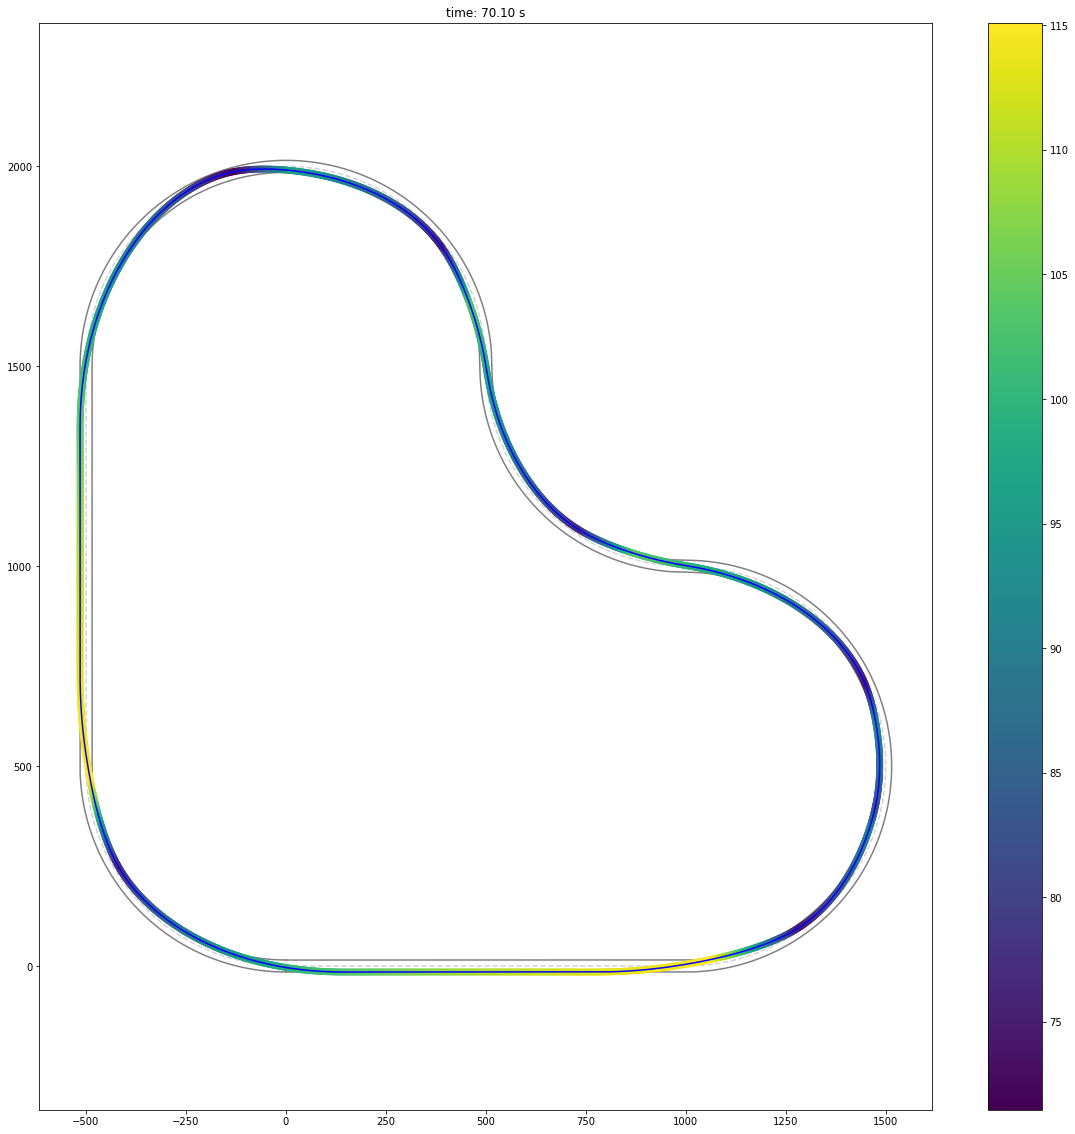

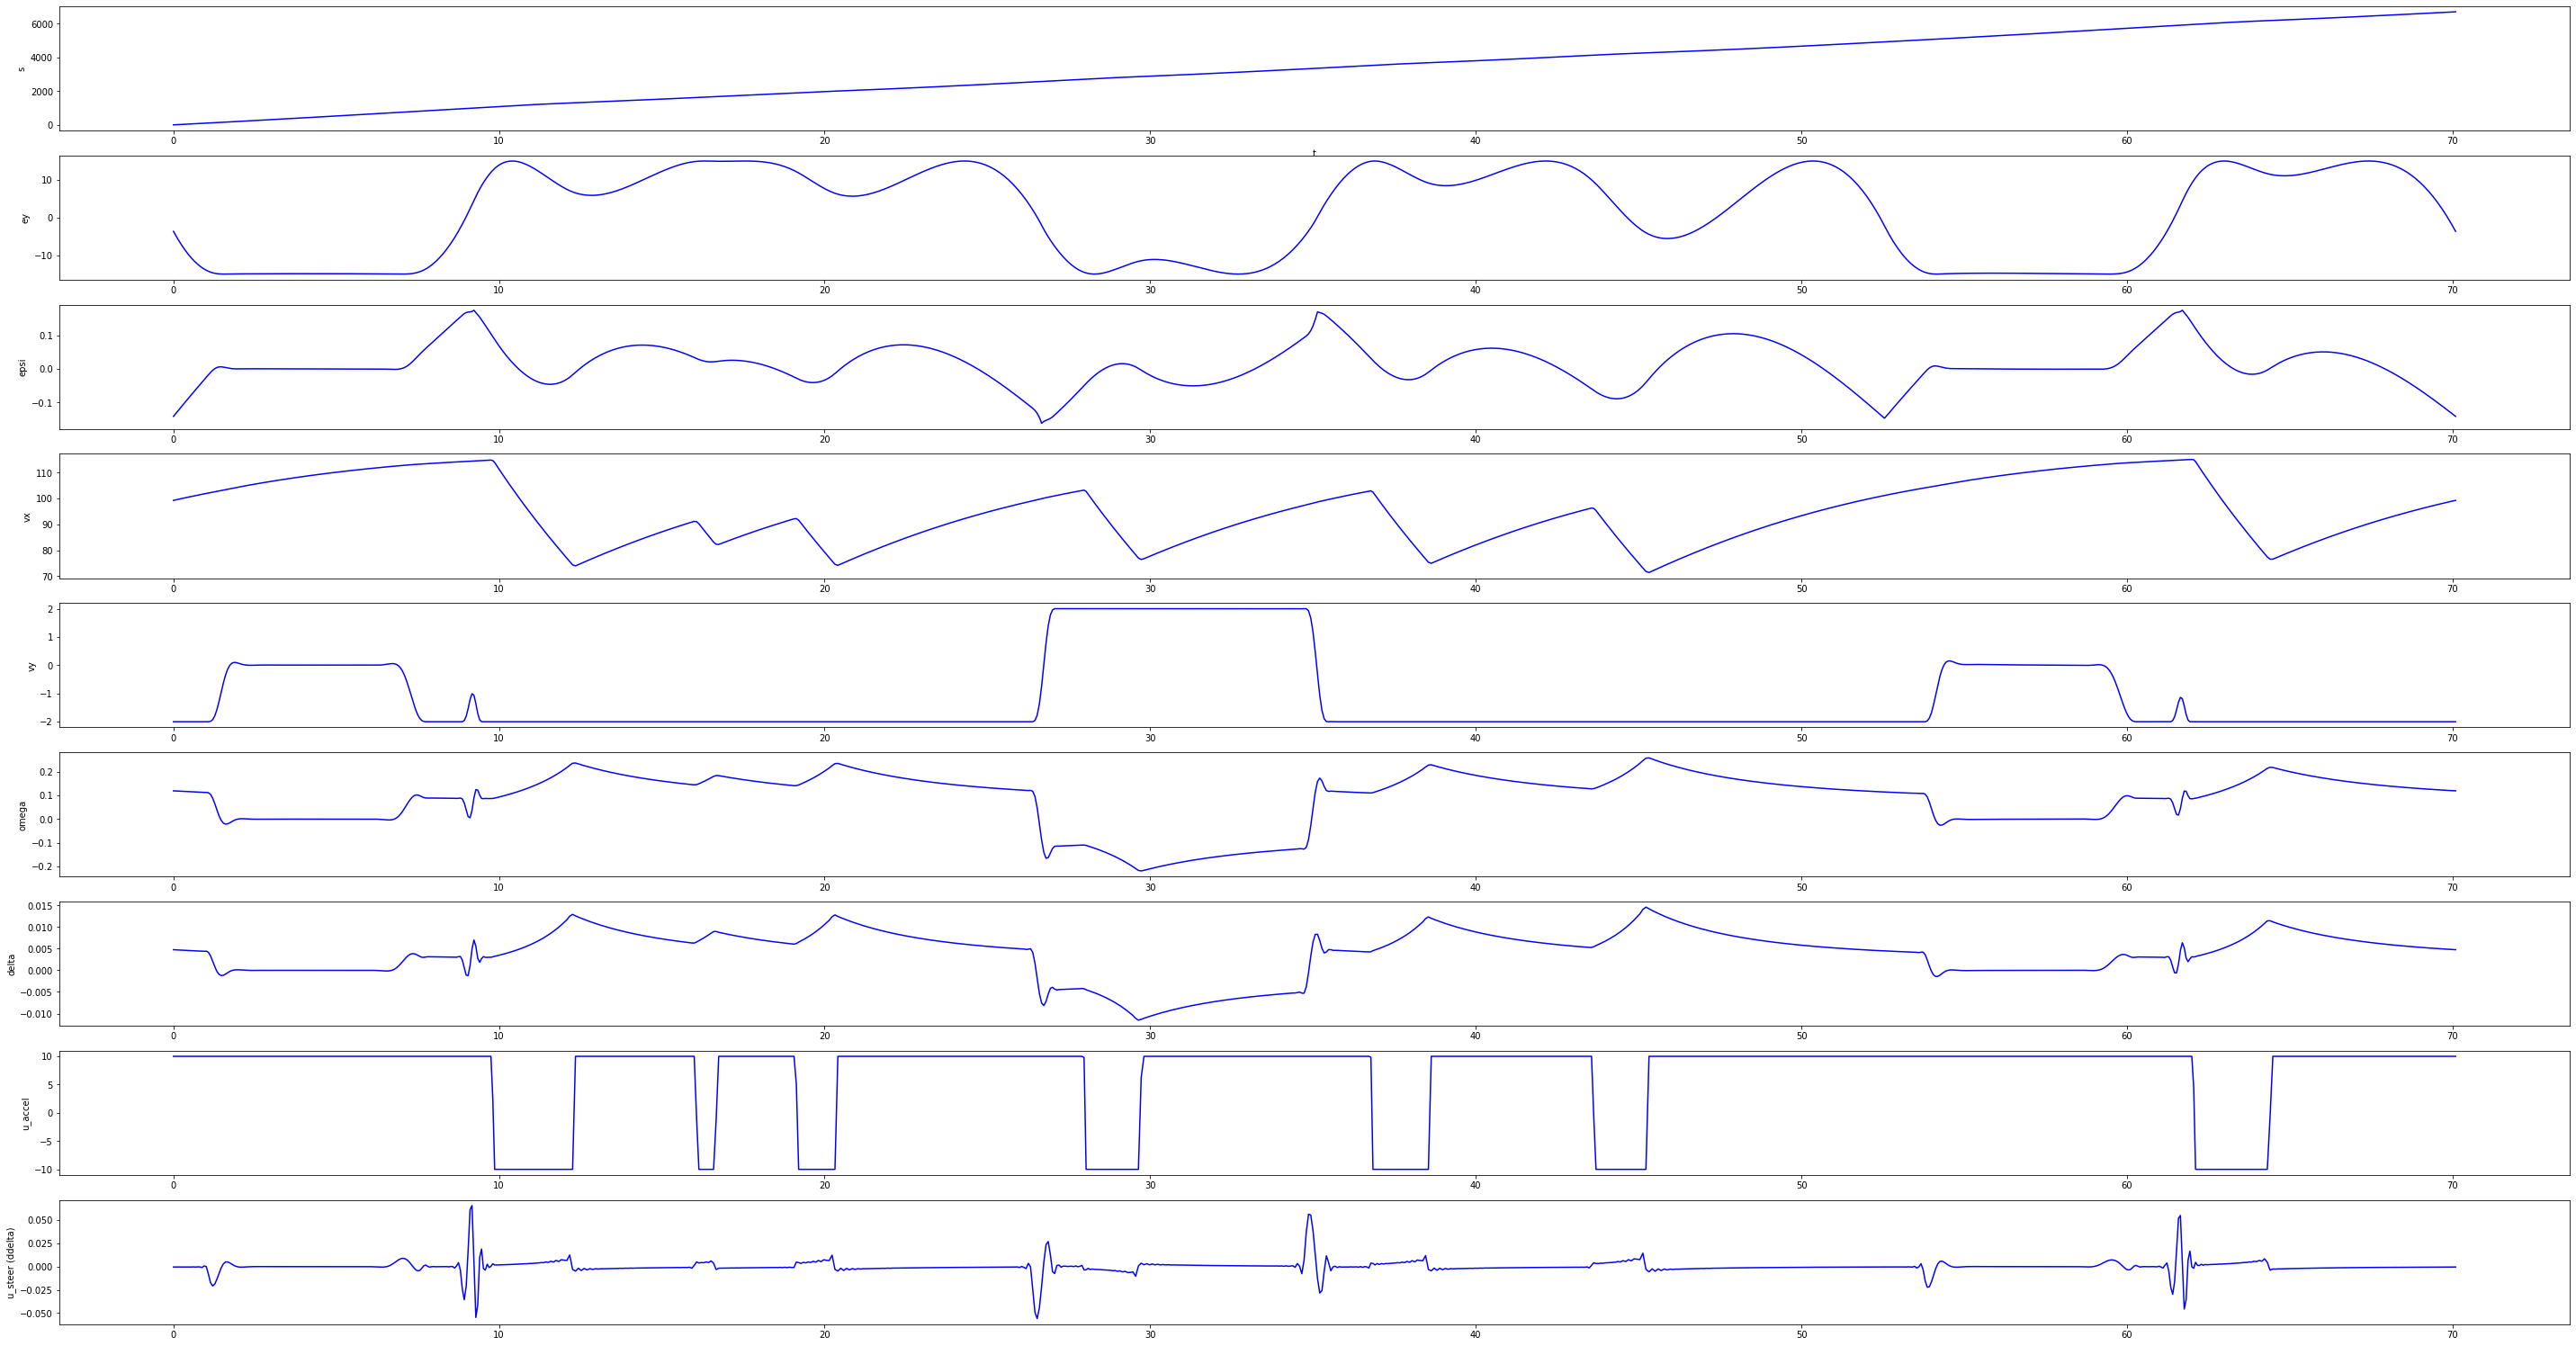

In [11]:
# Plot raceline
plot_racelines(L_track, L_raceline)

# Save raceline
filename = 'L_raceline.npz'
np.savez(filename, **L_raceline)

In [ ]:
print(raceline['u_a'].shape)

# Oval Track Optimization

In [14]:
# Set up L track for optimization
oval_veh_config = get_vehicle_config()
oval_scene_config = get_scene_config(track_type=OVAL_TRACK)
oval_veh_constraints = get_vehicle_opt_constraints(oval_veh_config, oval_scene_config)
oval_track = oval_scene_config["track"]

In [15]:
print(oval_track.name)

OVAL w/Straight 1000, Curve Radius 250


In [16]:
oval_raceline, oval_model = compute_raceline(oval_track, oval_veh_config, oval_veh_constraints)

=================== Raceline computation ===================
Track name: OVAL w/Straight 1000, Curve Radius 250
     - length: 3570.8 m
     - width: 20 m
Vehicle configuration:
     - center of mass to front axle: 2 m
     - center of mass to rear axle: 2 m
     - mass: 800 kg
     - yaw inertia: 1800 kg m^2
     - Drag Coefficient: 0.56
     - frontal area: 2 m^2
     - Front Tire Coefficient : 210000 N/rad
     - Rear Tire Coefficient : 210000 N/rad
Vehicle input constraints:
     - max acceleration: 10 m/s^2
     - min acceleration: -10 m/s^2
     - max steering angle: 0.5 rad
     - min steering angle: -0.5 rad
Vehicle state constraints:
     - max longitudinal velocity: 200 m/s
     - min longitudinal velocity: 0 m/s
     - max lateral velocity: 2 m/s
     - min lateral velocity: -2 m/s
     - max yaw rate: 1 rad/s
     - min yaw rate: -1 rad/s
of finite elements specified in apply. The larger number of finite elements
will be used.
Ipopt 3.13.4: max_iter=10000


****************

  65  7.2313276e+01 4.81e-02 2.28e+03  -1.0 3.30e+01  -0.8 2.49e-02 6.51e-03h  1
  66  7.2344273e+01 4.80e-02 2.26e+03  -1.0 5.63e+01  -1.3 1.30e-03 2.63e-03h  1
  67  7.2400605e+01 4.78e-02 2.18e+03  -1.0 3.51e+01  -0.9 2.49e-03 4.75e-03f  1
  68  7.2699639e+01 4.66e-02 2.14e+03  -1.0 7.28e+01  -1.3 2.85e-02 2.57e-02f  1
  69  7.2968228e+01 4.55e-02 2.76e+03  -1.0 3.21e+01  -0.9 5.03e-02 2.34e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  70  7.2998221e+01 4.54e-02 2.75e+03  -1.0 5.14e+01  -1.4 2.88e-03 2.65e-03h  1
  71  7.3946677e+01 4.18e-02 1.92e+03  -1.0 2.68e+01  -1.0 1.66e-03 8.37e-02f  1
  72  7.3957119e+01 4.17e-02 1.91e+03  -1.0 3.92e+01  -1.4 8.97e-03 1.01e-03h  1
  73  7.4548616e+01 3.94e-02 2.11e+03  -1.0 2.36e+01  -1.0 1.44e-03 5.73e-02h  1
  74  7.4975213e+01 3.77e-02 2.14e+03  -1.0 7.87e+01  -1.5 6.02e-03 4.45e-02f  1
  75  7.4983675e+01 3.76e-02 2.01e+03  -1.0 2.03e+01  -1.1 1.35e-02 9.25e-04h  1
  76  7.5424934e+01 3.59e-02

 158  1.0879711e+02 3.63e-03 1.61e+02  -1.0 2.14e+00  -2.2 1.00e+00 1.00e+00f  1
 159  1.0938323e+02 7.04e-02 1.91e+02  -1.0 7.44e+00  -2.6 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 160  1.0961563e+02 2.31e-03 6.12e+01  -1.0 2.08e+00  -2.2 1.00e+00 1.00e+00f  1
 161  1.1033209e+02 6.63e-02 1.04e+02  -1.0 8.41e+00  -2.7 1.00e+00 1.00e+00f  1
 162  1.1060840e+02 1.01e-02 2.41e+02  -1.0 1.43e+00  -2.3 1.00e+00 1.00e+00f  1
 163  1.1141690e+02 4.59e-02 3.37e+02  -1.0 4.07e+00  -2.7 1.00e+00 1.00e+00f  1
 164  1.1372780e+02 4.44e-01 1.47e+03  -1.0 6.42e+00  -3.2 1.00e+00 1.00e+00f  1
 165  1.1458394e+02 8.93e-03 1.89e+02  -1.0 3.05e+00  -2.8 1.00e+00 1.00e+00f  1
 166  1.1687987e+02 3.10e-01 1.08e+03  -1.0 2.69e+01  -3.3 6.09e-01 9.66e-01f  1
 167  1.1775297e+02 3.41e-02 1.27e+02  -1.0 1.21e+01  -2.8 1.00e+00 1.00e+00f  1
 168  1.1795126e+02 8.85e-02 2.15e+02  -1.0 1.23e+01  -2.4 9.47e-01 5.80e-01f  1
 169  1.1804103e+02 9.75e-02

 251  7.5710208e+01 4.47e-03 3.51e-01  -3.8 3.02e+01  -5.5 9.99e-01 6.92e-01f  1
 252  7.5498982e+01 1.38e-03 6.61e-02  -3.8 4.98e+01  -5.9 8.28e-01 8.83e-01f  1
 253  7.5286388e+01 3.18e-03 4.69e-01  -3.8 1.88e+02  -6.4 2.53e-01 3.11e-01f  1
 254  7.5143702e+01 2.34e-03 4.63e-01  -3.8 7.16e+01  -6.0 7.07e-01 5.56e-01f  1
 255  7.5046410e+01 1.86e-03 3.41e-02  -3.8 2.91e+01  -5.6 1.00e+00 1.00e+00f  1
 256  7.4930538e+01 3.85e-03 9.55e-02  -3.8 1.32e+02  -6.0 2.93e-01 3.87e-01f  1
 257  7.4866124e+01 1.99e-03 1.10e+00  -3.8 2.28e+01  -5.6 1.00e+00 5.90e-01f  1
 258  7.4807894e+01 1.53e-03 2.17e+00  -3.8 7.99e+01  -6.1 7.79e-01 1.91e-01f  1
 259  7.4719700e+01 3.50e-04 3.49e-01  -3.8 3.25e+01  -5.7 1.00e+00 7.84e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 260  7.4410153e+01 6.83e-03 1.07e+00  -3.8 1.17e+02  -6.2 6.86e-01 1.00e+00f  1
 261  7.4107082e+01 2.11e-02 9.50e-01  -3.8 4.60e+02  -6.6 1.82e-01 3.16e-01f  1
 262  7.4058623e+01 1.01e-03

 344  6.4461884e+01 2.30e-03 1.24e+01  -5.7 2.15e+02  -6.5 1.04e-02 1.54e-02h  1
 345  6.4354755e+01 2.00e-03 8.19e+00  -5.7 1.22e+02  -7.0 8.87e-02 2.28e-01f  1
 346  6.4331683e+01 1.98e-03 8.05e+00  -5.7 3.23e+02  -7.4 1.83e-02 1.77e-02f  1
 347  6.4189121e+01 1.87e-03 4.42e+00  -5.7 1.35e+02  -7.0 1.12e-01 2.74e-01f  1
 348  6.4099247e+01 1.85e-03 3.73e+00  -5.7 4.72e+02  -7.5 1.03e-02 6.31e-02f  1
 349  6.4091030e+01 1.64e-03 2.65e+00  -5.7 3.09e+01  -6.2 3.10e-02 1.15e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 350  6.4089130e+01 1.52e-03 4.61e+00  -5.7 1.19e+01  -5.7 3.62e-01 7.40e-02f  1
 351  6.4007419e+01 2.08e-03 3.72e+00  -5.7 4.59e+01  -6.2 2.21e-01 1.00e+00h  1
 352  6.3974862e+01 6.26e-04 1.37e+00  -5.7 2.08e+01  -5.8 6.32e-01 1.00e+00h  1
 353  6.3945926e+01 3.65e-03 1.23e+00  -5.7 1.58e+02  -6.3 9.96e-02 2.64e-01h  1
 354  6.3928331e+01 2.38e-03 9.61e-01  -5.7 5.40e+01  -5.8 2.20e-01 6.07e-01f  1
 355  6.3918805e+01 2.18e-03

 437  5.9287829e+01 1.88e-04 1.49e-02  -5.7 4.09e+01  -6.6 7.73e-01 2.68e-01f  1
 438  5.9251242e+01 5.75e-05 2.59e-03  -5.7 1.59e+01  -6.2 6.08e-01 8.28e-01h  1
 439  5.9143218e+01 3.92e-04 2.45e-02  -5.7 3.97e+01  -6.7 1.32e-01 8.30e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 440  5.9095003e+01 9.02e-05 8.95e-04  -5.7 1.57e+01  -6.2 3.68e-01 1.00e+00f  1
 441  5.9088505e+01 8.00e-05 8.55e-04  -5.7 8.26e+01  -6.7 4.34e-02 4.46e-02h  1
 442  5.9043688e+01 9.39e-05 3.03e-02  -5.7 1.78e+01  -6.3 1.81e-01 8.26e-01f  1
 443  5.9023408e+01 2.63e-05 2.87e-04  -5.7 8.40e+00  -5.9 9.12e-01 1.00e+00f  1
 444  5.8970232e+01 4.27e-04 4.22e-03  -5.7 3.10e+01  -6.3 2.78e-01 8.70e-01f  1
 445  5.8966094e+01 3.54e-04 3.49e-03  -5.7 1.23e+01  -5.9 1.00e+00 1.78e-01f  1
 446  5.8945366e+01 2.53e-04 3.14e-03  -5.7 2.63e+01  -6.4 7.69e-02 3.02e-01f  1
 447  5.8925544e+01 1.48e-04 1.38e-03  -5.7 1.44e+01  -6.0 3.22e-01 7.61e-01f  1
 448  5.8915771e+01 1.33e-04

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 530  5.5753698e+01 4.53e-05 2.69e-03  -5.7 8.78e+01  -6.7 1.44e-01 5.13e-02f  1
 531  5.5728093e+01 1.06e-04 1.56e-02  -5.7 2.05e+01  -6.3 1.43e-01 7.20e-01f  1
 532  5.5722935e+01 1.01e-04 1.48e-02  -5.7 1.22e+02  -6.8 5.45e-02 4.79e-02f  1
 533  5.5704961e+01 9.32e-05 1.39e-02  -5.7 1.11e+02  -7.3 1.02e-01 5.80e-02f  1
 534  5.5685239e+01 3.57e-04 1.18e-02  -5.7 1.06e+02  -6.8 1.59e-02 1.65e-01f  1
 535  5.5664731e+01 3.83e-04 6.37e-03  -5.7 3.45e+01  -6.4 3.00e-01 4.53e-01f  1
 536  5.5608203e+01 4.07e-04 7.51e-03  -5.7 5.12e+01  -6.9 2.78e-01 4.34e-01f  1
 537  5.5529803e+01 2.34e-04 5.40e-03  -5.7 1.39e+02  -7.4 3.11e-01 2.04e-01f  1
 538  5.5187457e+01 2.51e-03 4.75e-03  -5.7 3.49e+02  -7.8 1.51e-01 3.17e-01f  1
 539  5.5128855e+01 2.51e-03 4.90e-03  -5.7 1.43e+03  -8.3 1.36e-02 2.11e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 540  5.5122902e+01 2.41e-03

 622  5.1235725e+01 4.91e-04 2.35e-02  -5.7 4.06e+02  -7.3 5.67e-03 2.82e-02f  1
 623  5.1218827e+01 4.73e-04 2.23e-02  -5.7 2.02e+02  -7.8 1.73e-01 3.30e-02f  1
 624  5.1159431e+01 4.54e-04 2.12e-02  -5.7 5.30e+02  -8.2 8.98e-02 4.18e-02f  1
 625  5.1122047e+01 2.19e-04 9.81e-03  -5.7 4.01e+01  -6.9 9.16e-02 5.10e-01f  1
 626  5.1043184e+01 1.31e-04 6.29e-03  -5.7 8.52e+01  -7.4 2.30e-01 3.64e-01f  1
 627  5.1027828e+01 1.26e-04 6.21e-03  -5.7 4.84e+02  -7.9 9.06e-03 2.44e-02f  1
 628  5.1014682e+01 7.04e-05 3.51e-03  -5.7 1.69e+01  -6.5 4.25e-01 4.33e-01f  1
 629  5.0982849e+01 4.20e-04 2.09e-03  -5.7 7.64e+01  -7.0 1.90e-01 3.47e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 630  5.0893970e+01 2.69e-04 1.57e-03  -5.7 1.20e+02  -7.5 2.55e-01 3.31e-01f  1
 631  5.0875937e+01 2.74e-04 1.46e-03  -5.7 4.12e+02  -8.0 3.57e-02 2.34e-02f  1
 632  5.0854015e+01 3.79e-04 1.38e-03  -5.7 2.32e+02  -7.5 4.21e-02 7.35e-02f  1
 633  5.0806289e+01 3.64e-04

 715  4.7417124e+01 1.97e-04 1.81e-03  -5.7 3.92e+01  -7.1 1.39e-01 1.00e+00f  1
 716  4.7390024e+01 4.86e-05 1.10e-05  -5.7 1.51e+01  -6.7 1.00e+00 1.00e+00h  1
 717  4.7364385e+01 2.27e-04 2.22e-03  -5.7 5.30e+01  -7.2 2.61e-01 3.13e-01h  1
 718  4.7343766e+01 1.03e-04 1.26e-03  -5.7 2.39e+01  -6.8 2.74e-01 6.73e-01f  1
 719  4.7336508e+01 1.12e-04 1.57e-03  -5.7 5.69e+01  -7.2 1.23e-01 7.80e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 720  4.7324950e+01 1.23e-04 1.11e-03  -5.7 6.73e+01  -7.3 5.83e-02 1.13e-01f  1
 721  4.7312682e+01 1.23e-04 7.07e-04  -5.7 2.22e+01  -6.9 2.49e-01 3.15e-01f  1
 722  4.7295813e+01 1.31e-04 6.48e-04  -5.7 9.09e+01  -7.3 1.06e-01 1.47e-01f  1
 723  4.7293719e+01 1.33e-04 5.47e-04  -5.7 2.55e+02  -7.8 6.82e-03 5.82e-03f  1
 724  4.7241535e+01 2.21e-04 3.79e-02  -5.7 1.72e+02  -7.9 3.93e-02 1.37e-01f  1
 725  4.7232297e+01 1.36e-04 1.79e-02  -5.7 1.03e+01  -6.5 3.88e-01 5.04e-01f  1
 726  4.7223608e+01 1.39e-04

 808  4.5227955e+01 1.96e-04 2.80e-02  -5.7 4.38e+02  -8.4 1.93e-02 3.50e-02f  1
 809  4.5183371e+01 1.91e-04 2.78e-02  -5.7 1.15e+03  -8.8 1.14e-02 2.24e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 810  4.5153881e+01 1.84e-04 2.54e-02  -5.7 4.76e+02  -8.4 5.80e-02 3.54e-02f  1
 811  4.5114719e+01 1.80e-04 2.03e-02  -5.7 1.24e+03  -8.9 5.04e-02 1.82e-02f  1
 812  4.5082848e+01 1.73e-04 2.01e-02  -5.7 5.13e+02  -8.5 2.57e-02 3.55e-02f  1
 813  4.5025443e+01 1.68e-04 2.06e-02  -5.7 1.39e+03  -8.9 2.05e-02 2.47e-02f  1
 814  4.4982880e+01 1.95e-04 1.81e-02  -5.7 5.64e+02  -8.5 5.43e-02 4.36e-02f  1
 815  4.4934103e+01 2.64e-04 1.73e-02  -5.7 1.97e+03  -9.0 2.81e-02 1.97e-02f  1
 816  4.4931919e+01 2.61e-04 1.49e-02  -5.7 2.21e+02  -7.7 1.04e-01 1.49e-02f  1
 817  4.4903058e+01 3.50e-04 1.41e-02  -5.7 2.54e+02  -8.1 2.84e-02 6.90e-02f  1
 818  4.4849216e+01 4.88e-04 1.35e-02  -5.7 6.79e+02  -8.6 4.72e-02 4.66e-02f  1
 819  4.4842287e+01 4.87e-04

 901  4.3150568e+01 4.02e-04 3.55e-02  -5.7 1.00e+02  -7.6 6.88e-02 3.92e-01f  1
 902  4.3146141e+01 4.03e-04 3.37e-02  -5.7 4.54e+02  -8.1 1.01e-01 2.32e-02f  1
 903  4.3144750e+01 4.02e-04 3.32e-02  -5.7 4.02e+03  -8.5 8.47e-03 2.28e-03h  1
 904  4.3112750e+01 5.81e-04 3.13e-02  -5.7 2.44e+02  -8.1 7.94e-02 1.57e-01f  1
 905  4.3109800e+01 6.00e-04 2.89e-02  -5.7 1.07e+03  -8.6 2.93e-02 5.13e-03f  1
 906  4.3094966e+01 6.44e-04 3.00e-02  -5.7 2.81e+02  -8.2 2.49e-02 6.70e-02f  1
 907  4.3091545e+01 6.41e-04 2.70e-02  -5.7 6.10e+02  -8.6 3.41e-02 5.65e-03f  1
 908  4.3061752e+01 8.28e-04 3.16e-02  -5.7 3.10e+02  -8.2 1.37e-02 1.22e-01f  1
 909  4.3056675e+01 8.03e-04 2.54e-02  -5.7 1.68e+02  -7.8 1.56e-01 5.35e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 910  4.3048808e+01 7.86e-04 2.46e-02  -5.7 3.51e+02  -8.3 1.17e-01 2.91e-02f  1
 911  4.3026585e+01 7.61e-04 2.38e-02  -5.7 8.67e+02  -8.7 6.02e-02 3.00e-02f  1
 912  4.3008189e+01 7.13e-04

 994  4.1815686e+01 3.98e-04 2.00e-02  -5.7 2.89e+03  -9.5 6.41e-03 2.77e-02f  1
 995  4.1801463e+01 3.84e-04 1.93e-02  -5.7 1.15e+03  -9.1 4.56e-02 3.59e-02f  1
 996  4.1795973e+01 3.82e-04 1.92e-02  -5.7 4.90e+03  -9.6 6.88e-03 5.07e-03f  1
 997  4.1776857e+01 3.64e-04 1.84e-02  -5.7 1.28e+03  -9.1 5.55e-02 4.48e-02f  1
 998  4.1767336e+01 3.61e-04 1.82e-02  -5.7 3.93e+03  -9.6 7.77e-03 8.81e-03f  1
 999  4.1755113e+01 3.50e-04 1.77e-02  -5.7 1.39e+03  -9.2 1.22e-02 2.87e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1000  4.1753372e+01 3.47e-04 1.75e-02  -5.7 6.45e+02  -8.8 7.60e-02 9.70e-03f  1
1001  4.1731649e+01 3.31e-04 1.67e-02  -5.7 1.54e+03  -9.2 1.31e-02 4.53e-02f  1
1002  4.1728051e+01 3.30e-04 1.67e-02  -5.7 1.14e+04  -9.7 3.71e-03 2.80e-03f  1
1003  4.1717157e+01 3.27e-04 1.65e-02  -5.7 7.04e+03  -9.8 5.94e-03 7.98e-03f  1
1004  4.1706642e+01 3.21e-04 1.62e-02  -5.7 2.03e+03  -9.3 2.34e-02 1.87e-02f  1
1005  4.1704883e+01 3.18e-04

1087  4.1325063e+01 5.24e-04 1.25e-01  -5.7 7.92e+03  -9.7 6.79e-03 1.31e-02f  1
1088  4.1322236e+01 4.95e-04 1.17e-01  -5.7 8.42e+02  -9.2 5.68e-02 5.62e-02f  1
1089  4.1320094e+01 4.92e-04 1.11e-01  -5.7 1.40e+04  -9.7 1.47e-02 5.29e-03f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1090  4.1316420e+01 4.53e-04 1.38e-01  -5.7 9.55e+02  -9.3 1.71e-02 7.98e-02f  1
1091  4.1315674e+01 4.53e-04 1.38e-01  -5.7 3.02e+05  -9.8 2.28e-04 2.41e-04h  1
1092  4.1315553e+01 4.50e-04 1.44e-01  -5.7 2.64e+03  -9.4 5.96e-04 7.57e-03f  1
1093  4.1315305e+01 4.49e-04 1.37e-01  -5.7 3.99e+04  -9.8 4.36e-03 5.48e-04f  1
1094  4.1312175e+01 4.27e-04 1.44e-01  -5.7 1.45e+03  -9.4 2.69e-02 6.12e-02f  1
1095  4.1310134e+01 3.91e-04 1.58e-01  -5.7 3.97e+02  -9.0 2.17e-02 9.56e-02f  1
1096  4.1308647e+01 3.85e-04 1.54e-01  -5.7 1.78e+03  -9.5 1.98e-02 1.84e-02f  1
1097  4.1306259e+01 3.56e-04 1.60e-01  -5.7 4.36e+02  -9.0 4.56e-02 9.17e-02f  1
1098  4.1303268e+01 3.39e-04

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1180  4.1222347e+01 4.06e-04 5.36e-02  -5.7 7.54e+02    -  1.20e-01 9.39e-02f  1
1181  4.1222113e+01 3.41e-04 4.57e-02  -5.7 6.72e+02    -  1.02e-01 1.61e-01f  1
1182  4.1221875e+01 3.26e-04 4.40e-02  -5.7 1.45e+03 -10.3 8.67e-03 3.77e-02f  1
1183  4.1221731e+01 2.97e-04 4.07e-02  -5.7 8.42e+02    -  2.88e-02 8.74e-02f  1
1184  4.1221259e+01 5.13e-04 3.83e-02  -5.7 1.84e+03  -9.8 3.35e-02 5.54e-02f  1
1185  4.1221235e+01 5.14e-04 3.83e-02  -5.7 8.30e+03 -10.3 6.68e-03 5.07e-04h  1
1186  4.1221102e+01 5.26e-04 3.79e-02  -5.7 1.82e+03    -  3.95e-03 1.18e-02f  1
1187  4.1220866e+01 4.48e-04 3.47e-02  -5.7 7.12e+02    -  9.46e-02 1.59e-01f  1
1188  4.1220551e+01 5.10e-04 3.78e-02  -5.7 7.88e+02  -9.9 2.32e-02 5.89e-02f  1
1189  4.1220524e+01 5.09e-04 3.74e-02  -5.7 4.31e+03    -  6.82e-03 2.03e-03h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1190  4.1220462e+01 4.95e-04

Lap time: 41.203636906896435


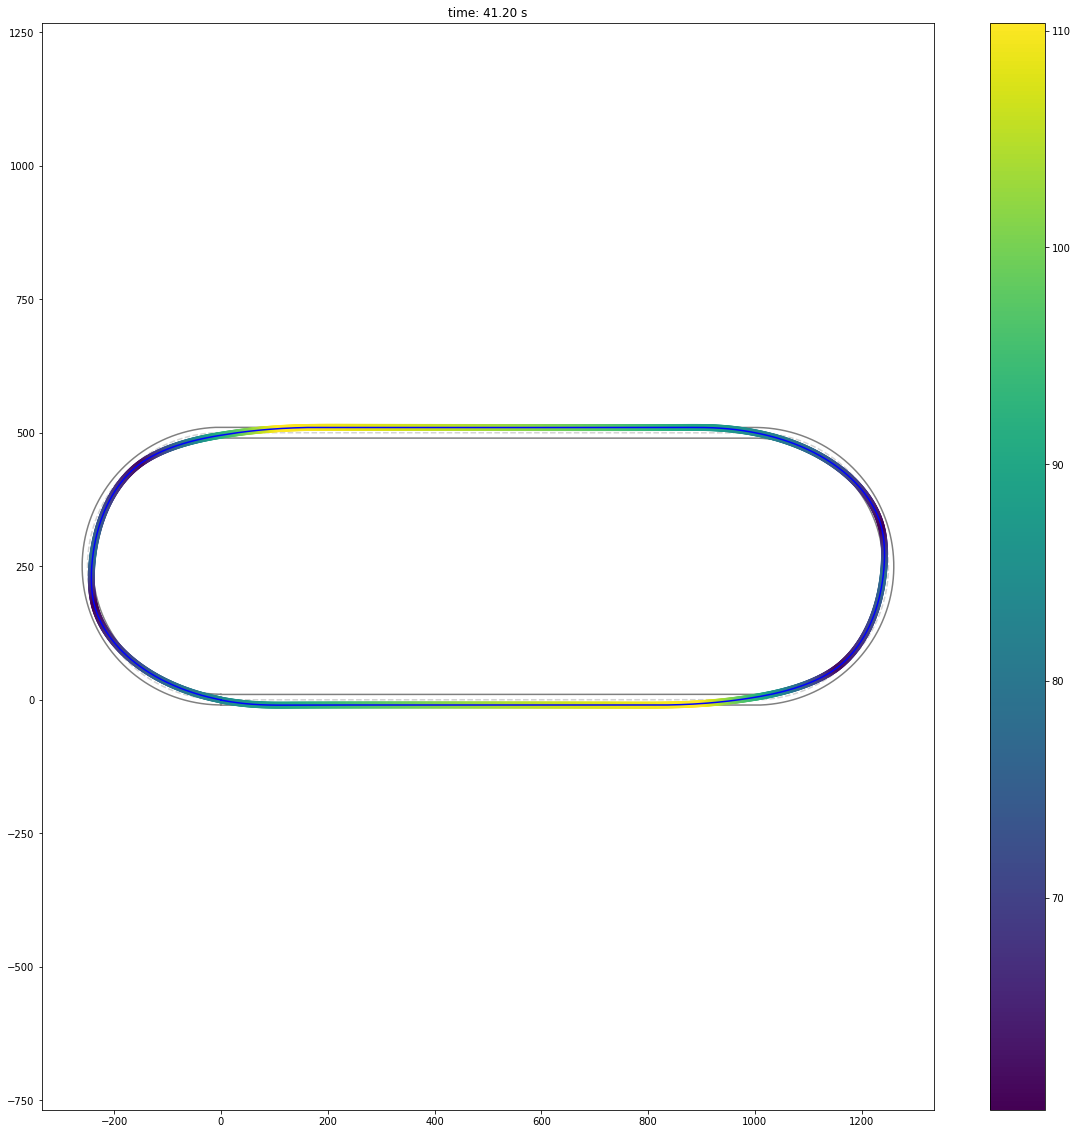

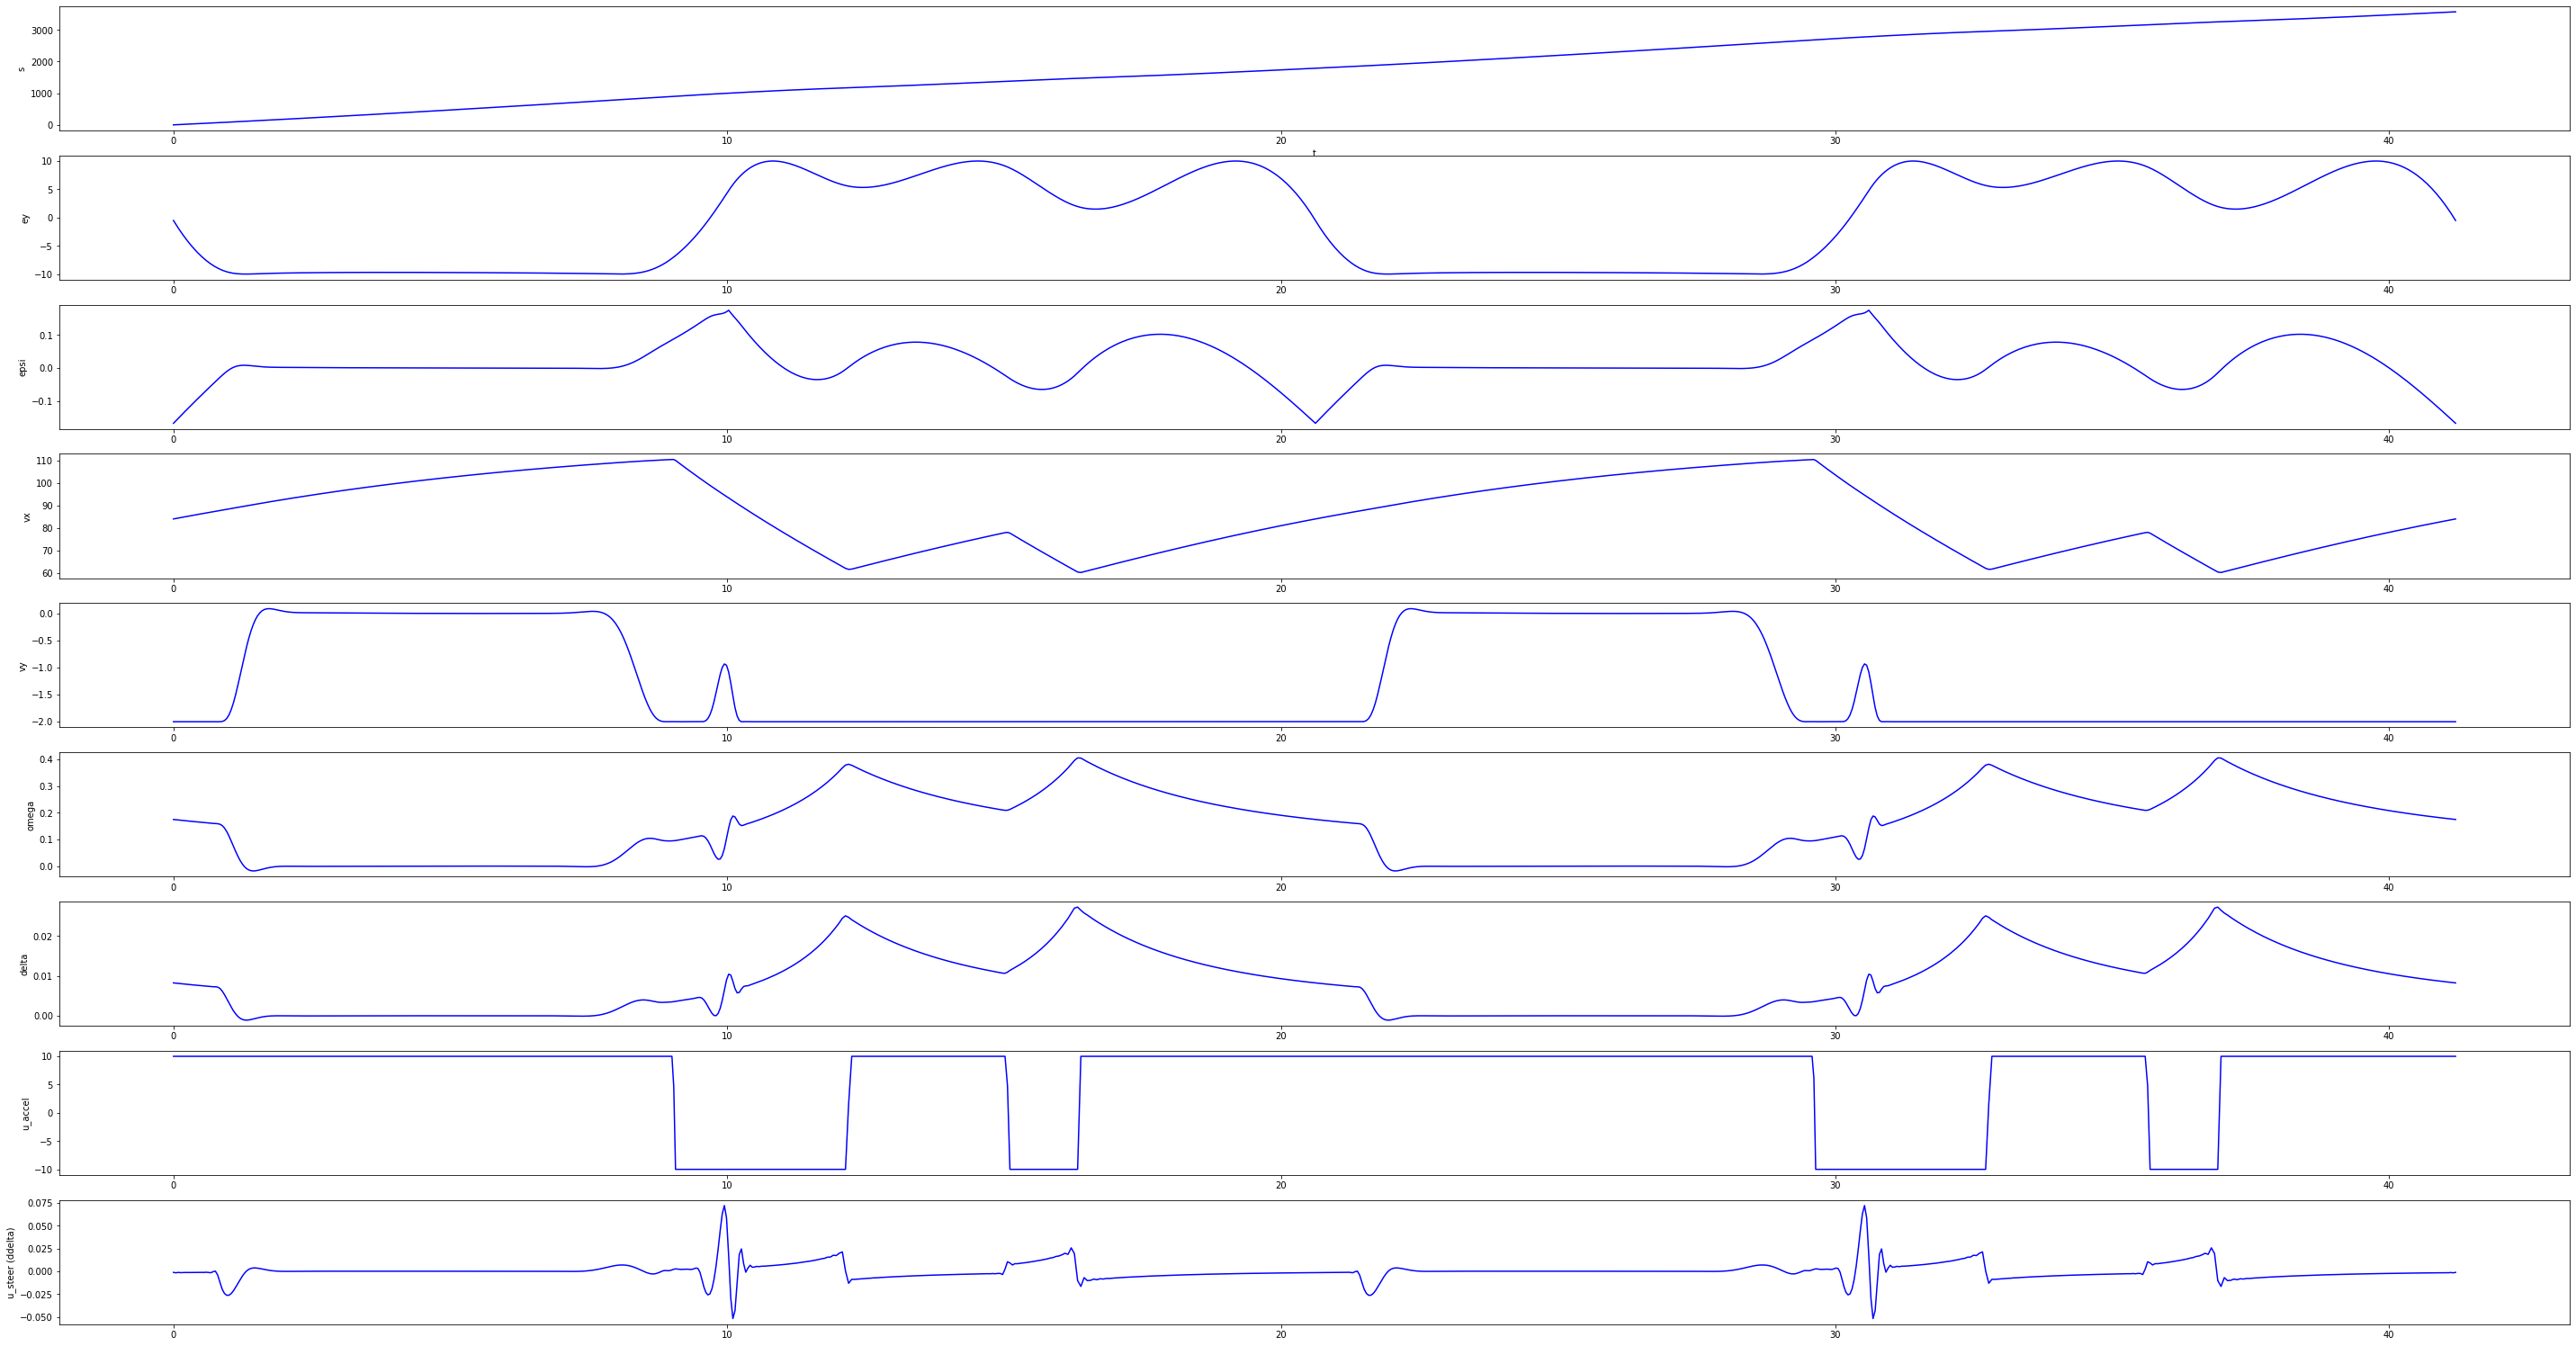

In [17]:
# Plot raceline
plot_racelines(oval_track, oval_raceline)

# Save raceline
filename = 'oval_raceline.npz'
np.savez(filename, **oval_raceline)

In [18]:
print(np.diff(oval_raceline['t']))

[0.02164009 0.02164009 0.02155827 ... 0.02167747 0.02170992 0.02170992]
